*Декомпозиция проекта*

Задача: Проанализировать поведение игроков игры "Космические братья" в зависимости от источника перехода и дать рекомендации по оптимизированию расходов на маркетинг


Основная монетизация игры — только планируется. Но предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки. Следовательно, нам необходимо выяснить, какие игроки лучше всего проходят на второй уровень, а значит больше вовлечены и строят больше объектов и видят больше рекламы. 

1. Знакомство с данными
- Посмотреть на данные всех датасетов
- Оценить объем работы 
- Проверить качество данных на первый взгляд

2. Предобработка данных
- Проверить данные на дубликаты и избавиться от них
- Проверить объем и критичность пропусков и решить что с ними делать 
- Заменить типы данных при необходимости

3. Исследовательский анализ данных
- Смерджить необходимые таблицы для удобного анализа на следующих этапах.
- Посмотреть кол-во уникальных значений в столбцах
- Определить из каких источников приходят игроки
- Определить как быстро они проходят игру и каким способом
- Определить кто из игроков перешел на следующий уровень через PVP(true), а кто через PVE(casual)
- Отследить весь lifetime каждого игрока
- Определить сколько стоят компании привлеченные игроки из разных источников

4. Анализ данных
- Выяснить, как влияют источники на поведение пользователей при прохождении игры
- Составить подробный портрет пользователей, пришедших из разных источников(канал привлечения, затраты на рекламу, предпочтения, способ игры, скорость прохождения и т.д.)
- Определить, какие внутриигровые факторы влияют на прохождение игры
- Определить, какие игроки больше строят(ведь реклама будет показываться в окне выбора постройки)
- Найти  ̶и̶ ̶у̶н̶и̶ч̶т̶о̶ж̶и̶т̶ь наиболее выгодных для компании игроков
- Сделать выводы 

5. Проверка статитстических гипотез
- Проверить гипотезу: время завершения уровня различается в зависимости способа прохождения(через реализацию проекта,через победу над первым игроком)
- Сформулировать собственную статистическую гипотезу и проверить её.(Лучшая гипотеза придет сама на этапе анализа данных)

6. Написать Выводы и рекомендации отделу маркетинга

***ОПИСАНИЕ ДАННЫХ*** 

Датасет *game_actions.csv*:

- `event_datetime` — время события;
- `event` — одно из трёх событий:
    1. `building` — объект построен,
    2. `finished_stage_1` — первый уровень завершён,
    3. `project` — проект завершён;
- `building_type` — один из трёх типов здания:
    1. `assembly_shop` — сборочный цех,
    2. `spaceport` — космопорт,
    3. `research_center` — исследовательский центр;
- `user_id` — идентификатор пользователя;
- `project_type` — тип реализованного проекта;

Помимо основного датасета есть два датасета с информацией о рекламных активностях. Они также помогут в решении задачи.

Датасет *ad_costs.csv*:

- `day` - день, в который был совершен клик по объявлению
- `source` - источник трафика
- `cost` - стоимость кликов

Датасет user_source.csv содержит колонки:

- `user_id` - идентификатор пользователя
- `source` - источников, с которого пришёл пользователь, установивший приложение

#  Презентация


https://disk.yandex.ru/i/r4VZ06s1LmWpFg

# Знакомство с данными

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from datetime import datetime
import plotly.express as px 
from plotly import graph_objects as go
import math as mth
from scipy import stats as st
import warnings
from scipy import stats as st

warnings.filterwarnings('ignore')

In [2]:
game = 'game_actions.csv'
user = 'user_source.csv'
ad = 'ad_costs.csv'


In [3]:
try:
    game_actions = pd.read_csv('/datasets/game_actions.csv')
    user_source = pd.read_csv('/datasets/user_source.csv')
    ad_cost = pd.read_csv('/datasets/ad_costs.csv')
    
except:
    game_actions = pd.read_csv(game)
    user_source = pd.read_csv(user)
    ad_cost = pd.read_csv(ad)

In [4]:
def check(df):
    print(df.info())
    print()
    print(df.describe().T)
    print()
    print('кол-во дубликатов:', df.duplicated().sum())
    print()
    print('кол-во пропусков:')
    print(df.isna().sum())
    display(df.head(10))

In [5]:
check(game_actions)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB
None

                 count  unique                                   top    freq
event_datetime  135640  128790                   2020-05-07 03:10:43       4
event           135640       3                              building  127957
building_type   127957       3                             spaceport   59325
user_id         135640   13576  ff841992-d93b-462e-bc6e-18c24a514f36      22
project_type      1866       1            satellite_orbital_assembly    1866

кол-во дубликатов: 1

кол-во пропусков:
event_datetime         0
e

event_datetime     event  building_type  \
0  2020-05-04 00:00:01  building  assembly_shop   
1  2020-05-04 00:00:03  building  assembly_shop   
2  2020-05-04 00:00:16  building  assembly_shop   
3  2020-05-04 00:00:16  building  assembly_shop   
4  2020-05-04 00:00:35  building  assembly_shop   
5  2020-05-04 00:00:36  building  assembly_shop   
6  2020-05-04 00:00:36  building  assembly_shop   
7  2020-05-04 00:00:38  building  assembly_shop   
8  2020-05-04 00:00:44  building  assembly_shop   
9  2020-05-04 00:01:33  building  assembly_shop   

                                user_id project_type  
0  55e92310-cb8e-4754-b622-597e124b03de          NaN  
1  c07b1c10-f477-44dc-81dc-ec82254b1347          NaN  
2  6edd42cc-e753-4ff6-a947-2107cd560710          NaN  
3  92c69003-d60a-444a-827f-8cc51bf6bf4c          NaN  
4  cdc6bb92-0ccb-4490-9866-ef142f09139d          NaN  
5  06c592ca-902d-42bb-bac3-75ce84cca159          NaN  
6  4fe0f101-694b-4e31-9740-d1d87f7208ea          NaN  
7  beb8ca15-33a9-465d-b47b-89aa96f89c9a          NaN  
8  65a92713-5969-48b1-8945-bfefa5063887          NaN  
9  fa352362-d258-472c-b295-2796ccc39fa3          NaN

Итак, в датасете game_actions есть 1 явный дубликат, 7683 (5.6% от датасета)  пропусков в building_type и 133774(98% от датасета) в project_type. дата и время типа object, надо исправлять. Посмотрим на user_source

In [6]:
check(user_source)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB
None

         count unique                                   top  freq
user_id  13576  13576  418cee7f-b96b-4e45-8288-eb2f58b03404     1
source   13576      4                         yandex_direct  4817

кол-во дубликатов: 0

кол-во пропусков:
user_id    0
source     0
dtype: int64


user_id                   source
0  0001f83c-c6ac-4621-b7f0-8a28b283ac30             facebook_ads
1  00151b4f-ba38-44a8-a650-d7cf130a0105            yandex_direct
2  001aaea6-3d14-43f1-8ca8-7f48820f17aa  youtube_channel_reklama
3  001d39dc-366c-4021-9604-6a3b9ff01e25    instagram_new_adverts
4  002f508f-67b6-479f-814b-b05f00d4e995             facebook_ads
5  003b80c6-4164-4157-bb2a-03d0181d39c4            yandex_direct
6  003ee7e8-6356-4286-a715-62f22a18d2a1    instagram_new_adverts
7  004074f8-251a-4776-922c-8348dca1a2f6             facebook_ads
8  00440efd-aa50-4b4b-aae8-ffcd1782729d             facebook_ads
9  00464e5e-28ed-4be6-bf44-517ef7b3937b            yandex_direct

Пропусков и дубликатов нет, 13576  уникальных юзеров, что совпадает с game_actions, здесь всё прекрасно 

In [7]:
check(ad_cost)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes
None

      count        mean        std        min        25%         50%  \
cost   28.0  271.556321  286.86765  23.314669  66.747365  160.056443   

             75%         max  
cost  349.034473  969.139394  

кол-во дубликатов: 0

кол-во пропусков:
source    0
day       0
cost      0
dtype: int64


source         day        cost
0           facebook_ads  2020-05-03  935.882786
1           facebook_ads  2020-05-04  548.354480
2           facebook_ads  2020-05-05  260.185754
3           facebook_ads  2020-05-06  177.982200
4           facebook_ads  2020-05-07  111.766796
5           facebook_ads  2020-05-08   68.009276
6           facebook_ads  2020-05-09   38.723350
7  instagram_new_adverts  2020-05-03  943.204717
8  instagram_new_adverts  2020-05-04  502.925451
9  instagram_new_adverts  2020-05-05  313.970984

Приведем дату в нужный формат, в остальном все тоже хорошо

# Предобработка данных

Сначала разберемся с game_actions

In [8]:
game_actions.head()

event_datetime     event  building_type  \
0  2020-05-04 00:00:01  building  assembly_shop   
1  2020-05-04 00:00:03  building  assembly_shop   
2  2020-05-04 00:00:16  building  assembly_shop   
3  2020-05-04 00:00:16  building  assembly_shop   
4  2020-05-04 00:00:35  building  assembly_shop   

                                user_id project_type  
0  55e92310-cb8e-4754-b622-597e124b03de          NaN  
1  c07b1c10-f477-44dc-81dc-ec82254b1347          NaN  
2  6edd42cc-e753-4ff6-a947-2107cd560710          NaN  
3  92c69003-d60a-444a-827f-8cc51bf6bf4c          NaN  
4  cdc6bb92-0ccb-4490-9866-ef142f09139d          NaN

In [9]:
game_actions = game_actions.drop_duplicates().reset_index(drop=True) #Удаляем дубликат
game_actions.duplicated().sum()

0

Обнаружен и удален один дубликат 

In [10]:
game_actions['event'].value_counts()

building            127956
finished_stage_1      5817
project               1866
Name: event, dtype: int64

In [11]:

game_actions['event_datetime'] = pd.to_datetime(game_actions['event_datetime'], format='%Y-%m-%d')
game_actions['day'] =game_actions['event_datetime'].dt.date
game_actions['day'] = pd.to_datetime(game_actions['day'], format='%Y-%m-%d')

game_actions.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135639 entries, 0 to 135638
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_datetime  135639 non-null  datetime64[ns]
 1   event           135639 non-null  object        
 2   building_type   127956 non-null  object        
 3   user_id         135639 non-null  object        
 4   project_type    1866 non-null    object        
 5   day             135639 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(4)
memory usage: 6.2+ MB


Перевели дату в формат datetime и добавили стобцев day, без времени, остальные колонки не будем менять на категориальные значения, т.к. датасет небольшой и нет особой нагрузки. Взглянем на пропуски 

In [12]:
game_actions['building_type'].value_counts()

spaceport          59325
assembly_shop      54494
research_center    14137
Name: building_type, dtype: int64

In [13]:
game_actions['building_type'].isna().sum()

7683

5,6% событий не связаны со строительством здания, заменим пропуски на 'no_building', чтобы отличать их в дальнейшем. 

In [14]:
game_actions['building_type'] = game_actions['building_type'].fillna('no_building')
game_actions['building_type'].value_counts()

spaceport          59325
assembly_shop      54494
research_center    14137
no_building         7683
Name: building_type, dtype: int64

In [15]:
game_actions.groupby(['event','building_type']).agg('count')

event_datetime  user_id  project_type    day
event            building_type                                                
building         assembly_shop             54494    54494             0  54494
                 research_center           14137    14137             0  14137
                 spaceport                 59325    59325             0  59325
finished_stage_1 no_building                5817     5817             0   5817
project          no_building                1866     1866          1866   1866

Все верно, эвенты finished_stage_1 и project не связаны с постройкой здания. Посмотрим на  project_type

In [16]:
game_actions['project_type'].value_counts()

satellite_orbital_assembly    1866
Name: project_type, dtype: int64

У нас есть данные только о завершении проекта "разработка орбитальной сборки спутников", т.к. это обязательное условия для победы, то можно предположить, что данные собираются только в случае реализации именно этого проекта, а наличие пропусков означает, что игрок этот проект не реализовал.

Заполним пропуски нулями.

In [17]:
game_actions['project_type'] = game_actions['project_type'].fillna(0)
game_actions['project_type'].value_counts()

0                             133773
satellite_orbital_assembly      1866
Name: project_type, dtype: int64

In [18]:
game_actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135639 entries, 0 to 135638
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_datetime  135639 non-null  datetime64[ns]
 1   event           135639 non-null  object        
 2   building_type   135639 non-null  object        
 3   user_id         135639 non-null  object        
 4   project_type    135639 non-null  object        
 5   day             135639 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(4)
memory usage: 6.2+ MB


Готово, присутпим к ad_cost

In [19]:
ad_cost['day'] = pd.to_datetime(ad_cost['day'], format='%Y-%m-%d')
ad_cost.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   source  28 non-null     object        
 1   day     28 non-null     datetime64[ns]
 2   cost    28 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 800.0+ bytes


Заменили day на тип datetime

## Вывод

Предобработка данных завершена, мы заменили дату на тип datetime, добавили стобце day в game_actions и  удалили 1 дубликат и заполнили пропуски. B выявили, что всего у нас есть данные 13 576 игроков

Нужно сообщить разработчикам об особенностях сбора данных по столбцу project_type, если в игре есть еще какие-либо проекты, которые можно реализовывать кроме орбитальной сборки спутников, то было бы здорово, если бы мы тоже имели эти данные

# Анализ Игроков

## Собираем датафрейм с рекламными источниками

Посмотрим, данными за какой период мы обладаем 

In [20]:
game_actions.head()

event_datetime     event  building_type  \
0 2020-05-04 00:00:01  building  assembly_shop   
1 2020-05-04 00:00:03  building  assembly_shop   
2 2020-05-04 00:00:16  building  assembly_shop   
3 2020-05-04 00:00:16  building  assembly_shop   
4 2020-05-04 00:00:35  building  assembly_shop   

                                user_id project_type        day  
0  55e92310-cb8e-4754-b622-597e124b03de            0 2020-05-04  
1  c07b1c10-f477-44dc-81dc-ec82254b1347            0 2020-05-04  
2  6edd42cc-e753-4ff6-a947-2107cd560710            0 2020-05-04  
3  92c69003-d60a-444a-827f-8cc51bf6bf4c            0 2020-05-04  
4  cdc6bb92-0ccb-4490-9866-ef142f09139d            0 2020-05-04

In [21]:
game_actions['event_datetime'].min()

Timestamp('2020-05-04 00:00:01')

In [22]:
game_actions['event_datetime'].max()

Timestamp('2020-06-05 12:32:49')

В  game_actions мы обладаем данными событий с 4 мая по 5 июня 

In [23]:
ad_cost['day'].min()

Timestamp('2020-05-03 00:00:00')

In [24]:
ad_cost['day'].max()

Timestamp('2020-05-09 00:00:00')

в ad_cost пользователи пришедшие с 3 мая по 9 мая 

Посмотрим на даты первого посещение всех пользователей

In [25]:
(game_actions.groupby('user_id').agg({'event_datetime':'first'}).reset_index())['event_datetime'].min()

Timestamp('2020-05-04 00:00:01')

In [26]:
(game_actions.groupby('user_id').agg({'event_datetime':'first'}).reset_index())['event_datetime'].max()

Timestamp('2020-05-10 23:59:52')

Т.к. от заказчика есть информация, что в датасете содержатся данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно, будем считать, что мы оплачиваем рекламу авансом, поэтому сдвигаем даты на 1 день.

In [27]:
ad_cost.head()

source        day        cost
0  facebook_ads 2020-05-03  935.882786
1  facebook_ads 2020-05-04  548.354480
2  facebook_ads 2020-05-05  260.185754
3  facebook_ads 2020-05-06  177.982200
4  facebook_ads 2020-05-07  111.766796

In [28]:
ad_cost['day'] = ad_cost['day'] + pd.Timedelta("1 day")
ad_cost.head()


source        day        cost
0  facebook_ads 2020-05-04  935.882786
1  facebook_ads 2020-05-05  548.354480
2  facebook_ads 2020-05-06  260.185754
3  facebook_ads 2020-05-07  177.982200
4  facebook_ads 2020-05-08  111.766796

In [29]:
ad_cost['day'].min()

Timestamp('2020-05-04 00:00:00')

In [30]:
ad_cost['day'].max()

Timestamp('2020-05-10 00:00:00')

Готово, давайте сделаем датафрейм с первым посещением уникальными пользователями и смерджим их с рекламой

In [31]:
df =game_actions.groupby('user_id').agg({'day':'first', 'event':'count'}).reset_index()
df = df.merge(user_source, on ='user_id', how = 'outer')
df = df.merge(ad_cost, how= 'outer', on =['day', 'source'])
df

user_id        day  event         source  \
0      0001f83c-c6ac-4621-b7f0-8a28b283ac30 2020-05-06     13   facebook_ads   
1      01303c2e-7de1-4742-8c3e-daf182b67b9f 2020-05-06      4   facebook_ads   
2      0136963c-c45c-4edb-92d8-205bd50a4d36 2020-05-06     12   facebook_ads   
3      018793d6-38c8-450a-bd54-8c181d920f1a 2020-05-06     14   facebook_ads   
4      01e2b256-4519-493f-b010-4a90a2755245 2020-05-06      9   facebook_ads   
...                                     ...        ...    ...            ...   
13571  f904bb06-e8f9-4aef-8773-5a47f12ac103 2020-05-08      5  yandex_direct   
13572  fa1ffc17-0032-4b4d-ac0d-6c75b890db9e 2020-05-08     12  yandex_direct   
13573  fd7d35ce-430b-40e0-a325-9d2b27b425e5 2020-05-08      9  yandex_direct   
13574  fec9a806-0291-4d46-914b-e4dd14ad3864 2020-05-08     10  yandex_direct   
13575  ff77733a-62a1-4d5b-9eb5-034222f24609 2020-05-08      3  yandex_direct   

             cost  
0      260.185754  
1      260.185754  
2      260.185754  
3      260.185754  
4      260.185754  
...           ...  
13571  114.429338  
13572  114.429338  
13573  114.429338  
13574  114.429338  
13575  114.429338  

[13576 rows x 5 columns]

Отлично, теперь мы знаем сколько денег мы потратили на каждого пользователя и откуда он пришел. Посмотрим на поведение самих игроков

In [32]:
ft = game_actions.groupby(['user_id']).agg({'event_datetime': 'first' }).reset_index() # Считаем ЛайфТайм пользователей
ft = ft.rename(columns= {'event_datetime': 'first_event'})
lt = game_actions.groupby(['user_id']).agg({'event_datetime': 'max' }).reset_index()
lt = lt.rename(columns= {'event_datetime': 'last_event'})
fta= ft.merge(lt, on = 'user_id', how ='outer')
fta['lifetime'] = fta['last_event'] - fta['first_event']
df = df.merge(fta, on='user_id', how = 'outer')



df.head()

user_id        day  event        source  \
0  0001f83c-c6ac-4621-b7f0-8a28b283ac30 2020-05-06     13  facebook_ads   
1  01303c2e-7de1-4742-8c3e-daf182b67b9f 2020-05-06      4  facebook_ads   
2  0136963c-c45c-4edb-92d8-205bd50a4d36 2020-05-06     12  facebook_ads   
3  018793d6-38c8-450a-bd54-8c181d920f1a 2020-05-06     14  facebook_ads   
4  01e2b256-4519-493f-b010-4a90a2755245 2020-05-06      9  facebook_ads   

         cost         first_event          last_event         lifetime  
0  260.185754 2020-05-06 01:07:37 2020-05-20 11:26:06 14 days 10:18:29  
1  260.185754 2020-05-06 07:05:11 2020-05-08 22:30:49  2 days 15:25:38  
2  260.185754 2020-05-06 14:00:20 2020-05-25 08:56:48 18 days 18:56:28  
3  260.185754 2020-05-06 07:05:52 2020-05-24 23:52:53 18 days 16:47:01  
4  260.185754 2020-05-06 22:16:07 2020-05-21 04:52:31 14 days 06:36:24

In [33]:
df['first_event'].min()

Timestamp('2020-05-04 00:00:01')

In [34]:
df['last_event'].min()

Timestamp('2020-05-04 01:53:12')

In [35]:
df['lifetime'].min() # 0 lifetime????

Timedelta('0 days 00:00:00')

In [36]:
df.query('lifetime == "0 days 00:00:00"')

user_id        day  event  \
40     1cd22d84-9a82-402a-86ee-185e76eb7a6d 2020-05-06      1   
224    a3c28099-f67a-4796-aa1f-76c6085006b5 2020-05-06      1   
359    040813c5-ef43-49d0-bbb7-13c532efe6bc 2020-05-06      1   
399    106ce4de-1d43-4746-913d-bfa1d09128a0 2020-05-06      1   
510    3d2ac4d1-a405-4d14-b6e6-4ff5884d4f88 2020-05-06      1   
663    75fe68ea-7fc3-41f0-93ae-408d169dbe44 2020-05-06      1   
993    f93d4977-3ba5-408e-9025-b995e581f5b1 2020-05-06      1   
1635   f0841197-ade8-4cf4-ab47-e59e1a32d6b7 2020-05-05      1   
1639   f2750d16-16dc-420f-9a61-0a9c85308086 2020-05-05      1   
1662   fcefbdaa-5f8b-49a6-91f3-8c09e0a94a5d 2020-05-05      1   
1908   48a96c0c-7c59-4f43-a694-58568b8c6820 2020-05-05      1   
2773   707648a2-76fc-4297-8b1c-bcd84104a492 2020-05-05      1   
2831   83d9c3c0-35d0-434f-84d8-1ad2f6b606bb 2020-05-05      1   
3099   e49acc01-ccf6-42f8-aab4-9fc6aef66493 2020-05-05      1   
3158   feee0b06-fe5e-4ff9-b9d7-5061a3bf3c59 2020-05-05      1   
4387   960606ae-2765-484d-9ccb-df6404ef5389 2020-05-04      1   
4948   dac343d0-b438-4ea7-87a4-83ab7ed0b164 2020-05-04      1   
5165   f503e280-dfdd-439b-afcd-af93433aec42 2020-05-04      1   
7046   7ac32352-627b-421c-9319-b77a37947625 2020-05-04      1   
7374   c2da7069-de66-4cda-9072-a48efbeea8b6 2020-05-04      1   
8163   6c78f635-e4a9-435f-a2bb-154974d57646 2020-05-05      1   
8799   f6a91a2f-b1dd-4db2-bf11-532c8f893d24 2020-05-05      1   
8910   29ecf191-5706-420f-be38-28d52abbb069 2020-05-06      1   
8923   31d67118-da17-4d29-8d42-da15aaca6eb7 2020-05-06      1   
9077   a27a2f66-c7fc-4933-852c-8ff3d735646b 2020-05-06      1   
9109   b9d266a0-7741-49ba-9125-134c5969f8d1 2020-05-06      1   
9130   c4b5db5b-e669-423a-aa26-cacb2e41e6bd 2020-05-06      1   
9222   011e8846-9204-434b-809a-398310d730da 2020-05-04      1   
10233  b783fde3-5416-43fb-99b0-2c6e5f787d6f 2020-05-04      1   
10460  ded24248-15c7-4037-9092-f64fcaa651e7 2020-05-04      1   
10536  eb5d0be8-4daf-49da-ac22-ab8935ad8b2a 2020-05-04      1   
10728  545d5caa-999d-4f5f-a192-dee4d66d2f9d 2020-05-07      1   
10762  782a870b-99a9-452a-a41f-63c058d1174c 2020-05-07      1   
10817  b6f9f6b7-e899-4aed-9a19-ea3967f79af2 2020-05-07      1   
10939  70362b15-8a0b-4fb7-8a67-4454fd7098d7 2020-05-09      1   
11030  4b1e7dfa-4bb6-427c-8356-b05e8da28e28 2020-05-08      1   
11048  7c2021b7-1241-410d-80aa-25cfc8ee720d 2020-05-08      1   
11132  eca18734-a9f8-49f9-9fdc-b94c76a0263f 2020-05-08      1   
11803  f0425383-12f3-4a1d-9f8b-5ceea106a5f9 2020-05-06      1   
11906  8a6262b0-0521-4691-bfd2-8d74cf7a5e93 2020-05-09      1   
12394  dce8f331-d1ae-4d90-bc3e-0bc02929ea2e 2020-05-10      1   
12465  ce195017-5a23-4d75-924a-eb328262e838 2020-05-10      1   
12472  daea0325-f7c5-4008-b5f6-f89fc2c1e019 2020-05-10      1   
12476  e17fd642-a43d-41d4-86a8-c81c6107f9cc 2020-05-10      1   
12695  8a0c43d1-e44e-4799-845a-d4b61d00c0c7 2020-05-07      1   
12859  ebfe1d62-9750-483f-b1b1-5c04fd62ee39 2020-05-07      1   
12895  2314a28b-69a2-41f9-a3e8-e67423ee7d93 2020-05-10      1   
12896  281f725b-799a-4c3f-b3fc-4cd887d47aa3 2020-05-10      1   
13027  992bda38-85a5-4b56-a305-03dfe50a0a14 2020-05-09      1   
13127  531a93d9-f57d-4b60-8eec-ee709ff7c67c 2020-05-08      1   
13153  886c3d2d-a547-4f46-9d03-0722ba3b3f5e 2020-05-08      1   
13178  b47378f9-93fa-4491-9f2e-f68d3fab0132 2020-05-08      1   
13232  1510e855-52ac-4ffd-b9f9-291bc9b2e0cc 2020-05-09      1   
13320  d7c40393-6ac1-4a57-9d80-5ecdfe231e7b 2020-05-09      1   
13338  06d035a3-f3f0-4f3a-ae54-e4a7a33c1409 2020-05-08      1   
13367  2b44cf91-39c0-45d8-aa93-edb179682c6e 2020-05-08      1   
13499  bffb446d-dd9b-401a-b84f-73f5e1b38234 2020-05-08      1   

                        source        cost         first_event  \
40                facebook_ads  260.185754 2020-05-06 13:58:52   
224               facebook_ads  260.185754 2020-05-06 05:29:00   
359              yandex_direct  308.232990 2020-05-06 04:54:51   
3

In [37]:
len(df.query('lifetime == "0 days 00:00:00"'))

57

In [38]:
game_actions.query('user_id == "011e8846-9204-434b-809a-398310d730da"')

event_datetime     event  building_type  \
6177 2020-05-04 18:21:20  building  assembly_shop   

                                   user_id project_type        day  
6177  011e8846-9204-434b-809a-398310d730da            0 2020-05-04

57 пользователей зашли в игру, совериши один ивент и вышли. Исключать из анализа мы их не будем, т.к. деньги на них потрачены 

In [39]:
def win(row): # пишем функцию, чтобы которая простаовит игрокам 1 в случае победы и 0 в случае поражения 
    if row == 'finished_stage_1':
        return 1
    else:
        return 0

In [40]:
game_actions_test = game_actions.copy()                                                 
game_actions_test['win'] = game_actions_test['event'].apply(win) # вставляем в датафрейм функцию
asdad = game_actions_test.groupby('user_id').agg({'win':'sum'}).reset_index() #смотрим на победы уникальных пользователей
df = df.merge(asdad, how ='outer', on = 'user_id')
df

user_id        day  event         source  \
0      0001f83c-c6ac-4621-b7f0-8a28b283ac30 2020-05-06     13   facebook_ads   
1      01303c2e-7de1-4742-8c3e-daf182b67b9f 2020-05-06      4   facebook_ads   
2      0136963c-c45c-4edb-92d8-205bd50a4d36 2020-05-06     12   facebook_ads   
3      018793d6-38c8-450a-bd54-8c181d920f1a 2020-05-06     14   facebook_ads   
4      01e2b256-4519-493f-b010-4a90a2755245 2020-05-06      9   facebook_ads   
...                                     ...        ...    ...            ...   
13571  f904bb06-e8f9-4aef-8773-5a47f12ac103 2020-05-08      5  yandex_direct   
13572  fa1ffc17-0032-4b4d-ac0d-6c75b890db9e 2020-05-08     12  yandex_direct   
13573  fd7d35ce-430b-40e0-a325-9d2b27b425e5 2020-05-08      9  yandex_direct   
13574  fec9a806-0291-4d46-914b-e4dd14ad3864 2020-05-08     10  yandex_direct   
13575  ff77733a-62a1-4d5b-9eb5-034222f24609 2020-05-08      3  yandex_direct   

             cost         first_event          last_event         lifetime  \
0      260.185754 2020-05-06 01:07:37 2020-05-20 11:26:06 14 days 10:18:29   
1      260.185754 2020-05-06 07:05:11 2020-05-08 22:30:49  2 days 15:25:38   
2      260.185754 2020-05-06 14:00:20 2020-05-25 08:56:48 18 days 18:56:28   
3      260.185754 2020-05-06 07:05:52 2020-05-24 23:52:53 18 days 16:47:01   
4      260.185754 2020-05-06 22:16:07 2020-05-21 04:52:31 14 days 06:36:24   
...           ...                 ...                 ...              ...   
13571  114.429338 2020-05-08 15:11:26 2020-05-12 21:07:54  4 days 05:56:28   
13572  114.429338 2020-05-08 06:17:28 2020-05-24 12:50:48 16 days 06:33:20   
13573  114.429338 2020-05-08 23:59:00 2020-05-25 00:18:28 16 days 00:19:28   
13574  114.429338 2020-05-08 23:44:14 2020-05-20 01:25:10 11 days 01:40:56   
13575  114.429338 2020-05-08 22:53:20 2020-05-12 17:19:39  3 days 18:26:19   

       win  
0        0  
1        0  
2        1  
3        1  
4        0  
...    ...  
13571    0  
13572    1  
13573    1  
13574    0  
13575    0  

[13576 rows x 9 columns]

In [41]:
df['lifetime'].median()

Timedelta('10 days 12:30:52.500000')

Медианно жизнь игрока длится 10 с половиной дней.

In [42]:
df.query('win ==1')['lifetime'].median()

Timedelta('11 days 13:28:44')

Медианно жизнь игроков, которые проходят на второй уровень длится 11 с половиной дней

In [43]:
df.query('win ==0')['lifetime'].median()

Timedelta('9 days 14:34:59')

Медианно жизнь игроков, которые НЕ проходят на второй уровень длится 9 с половиной дней

В Этих данные есть игроки, которые играли и до июня(почти месяц), но это исключительный случай, именно по этому ориентируемся на медиану, а не на среднее

И так, у нас есть данные о всех уникальных игроках, источниках и стоимости их привлечения, лайф тайм и наличие прохождения 1 уровня. Давайте разбираться дальше

## Каким способом пользователи проходят игру

Для начала посмотрим на общий стиль игры, что любят строить игроки: 

In [44]:
building  = game_actions.query('building_type!= "no_building"')
building = building.groupby('building_type').agg({'event':'count'}).reset_index()
fig = px.pie(building, values='event', names='building_type', title='Соотношение построек в игре')
fig.show()

Чаще всего игроки строят космопорт(46.4%), потом  сборочный цех(42.6%), а вот  исследовательский центр строят очень редко, всего 11% от всех построек в игре.

Посмотрим на те же данные, но у победителей и забросивших игру/до сих пор не прошедших 1 уровень

In [45]:
winners = game_actions.query('event == "finished_stage_1"')
game_winners = game_actions.loc[game_actions['user_id'].isin(winners['user_id'])]  # Получаем дату game_actions по победителям
game_loosers = game_actions.loc[~game_actions['user_id'].isin(winners['user_id'])] # Получаем дату game_actions по не закончившим 1 уровень
game_winners.head()

event_datetime     event  building_type  \
1 2020-05-04 00:00:03  building  assembly_shop   
2 2020-05-04 00:00:16  building  assembly_shop   
4 2020-05-04 00:00:35  building  assembly_shop   
6 2020-05-04 00:00:36  building  assembly_shop   
8 2020-05-04 00:00:44  building  assembly_shop   

                                user_id project_type        day  
1  c07b1c10-f477-44dc-81dc-ec82254b1347            0 2020-05-04  
2  6edd42cc-e753-4ff6-a947-2107cd560710            0 2020-05-04  
4  cdc6bb92-0ccb-4490-9866-ef142f09139d            0 2020-05-04  
6  4fe0f101-694b-4e31-9740-d1d87f7208ea            0 2020-05-04  
8  65a92713-5969-48b1-8945-bfefa5063887            0 2020-05-04

In [46]:
len(game_winners.query('building_type!= "no_building"'))

60786

In [47]:
building_winners  = game_winners.query('building_type!= "no_building"')
building_winners = building_winners.groupby('building_type').agg({'event':'count'}).reset_index()
fig = px.pie(building_winners, values='event', names='building_type', title='Соотношение построек в игре у победителей')
fig.show()

In [48]:
building_loosers  = game_loosers.query('building_type!= "no_building"')
building_loosers = building_loosers.groupby('building_type').agg({'event':'count'}).reset_index()
fig = px.pie(building_loosers, values='event', names='building_type', title='Соотношение построек в игре у не прошедших на 2 уровень')
fig.show()

Соотношение построек почти такое же в обоих случая, разве что победители чаще строят исследовательский центр.

Мы знаем, что игру можно пройти 2умя способами:
- Победа над первым врагом
- Реализация проекта - разработка орбитальной сборки спутников

Давайте посмотрим, как игроки это делают

In [49]:
game_winners.head()

event_datetime     event  building_type  \
1 2020-05-04 00:00:03  building  assembly_shop   
2 2020-05-04 00:00:16  building  assembly_shop   
4 2020-05-04 00:00:35  building  assembly_shop   
6 2020-05-04 00:00:36  building  assembly_shop   
8 2020-05-04 00:00:44  building  assembly_shop   

                                user_id project_type        day  
1  c07b1c10-f477-44dc-81dc-ec82254b1347            0 2020-05-04  
2  6edd42cc-e753-4ff6-a947-2107cd560710            0 2020-05-04  
4  cdc6bb92-0ccb-4490-9866-ef142f09139d            0 2020-05-04  
6  4fe0f101-694b-4e31-9740-d1d87f7208ea            0 2020-05-04  
8  65a92713-5969-48b1-8945-bfefa5063887            0 2020-05-04

In [50]:
pve = game_winners.query('project_type != 0')
len(pve['user_id'].unique())

1866

In [51]:
pvp = game_winners.loc[~game_winners['user_id'].isin(pve['user_id'])]
len(pvp['user_id'].unique())

3951

In [52]:
len(game_winners['user_id'].unique())

5817

In [53]:
len(game_actions['user_id'].unique())

13576

Из 13576 игроков, установивших приложение - на второй уровень перешли 5817(42%) - не сказать, что это очень хорошая конверсия.

Из 5817 игроков, которые прошли на 2 уровень у 1866(32%) были построены орбитальные сборки спутников, а 3951(68%) завершили игроку без этой постройки, а значит за победу над перым игроков. Т.е. 68% игроков предпочитают PVP

Чтобы найти самых выгодных для компании клиентов нам нужно, чтобы эти игроки: 

1) Были вовлечены, а значит проходили первый уровень

2) Много строили, т.к. реклама будет показываться на этапе постройки здания 

Пострим на постройки у PVE и PVP юзеров: 

In [54]:
pve_bild = game_winners.loc[game_winners['user_id'].isin(pve['user_id'].unique())]
pve_bild_count = pve_bild.query('building_type!="no_building"')
pve_bild_count = pve_bild_count.groupby('building_type').agg({'event_datetime':'count','user_id':'nunique'}).reset_index().sort_values(by='event_datetime', ascending=False)

pve_bild_count['event_for_player'] = pve_bild_count['event_datetime']/pve_bild_count['user_id']
pve_bild_count

building_type  event_datetime  user_id  event_for_player
2        spaceport           10788     1866          5.781350
0    assembly_shop            9116     1866          4.885316
1  research_center            3697     1866          1.981243

In [55]:
pvp_bild = game_winners.loc[game_winners['user_id'].isin(pvp['user_id'].unique())]
pvp_bild_count = pvp_bild.query('building_type!="no_building"')
pvp_bild_count = pvp_bild_count.groupby('building_type').agg({'event_datetime':'count','user_id':'nunique'}).reset_index().sort_values(by='event_datetime', ascending=False)

pvp_bild_count['event_for_player'] = pvp_bild_count['event_datetime']/pvp_bild_count['user_id']
pvp_bild_count

building_type  event_datetime  user_id  event_for_player
2        spaceport           17132     3894          4.399589
0    assembly_shop           16298     3951          4.125032
1  research_center            3755     2342          1.603330

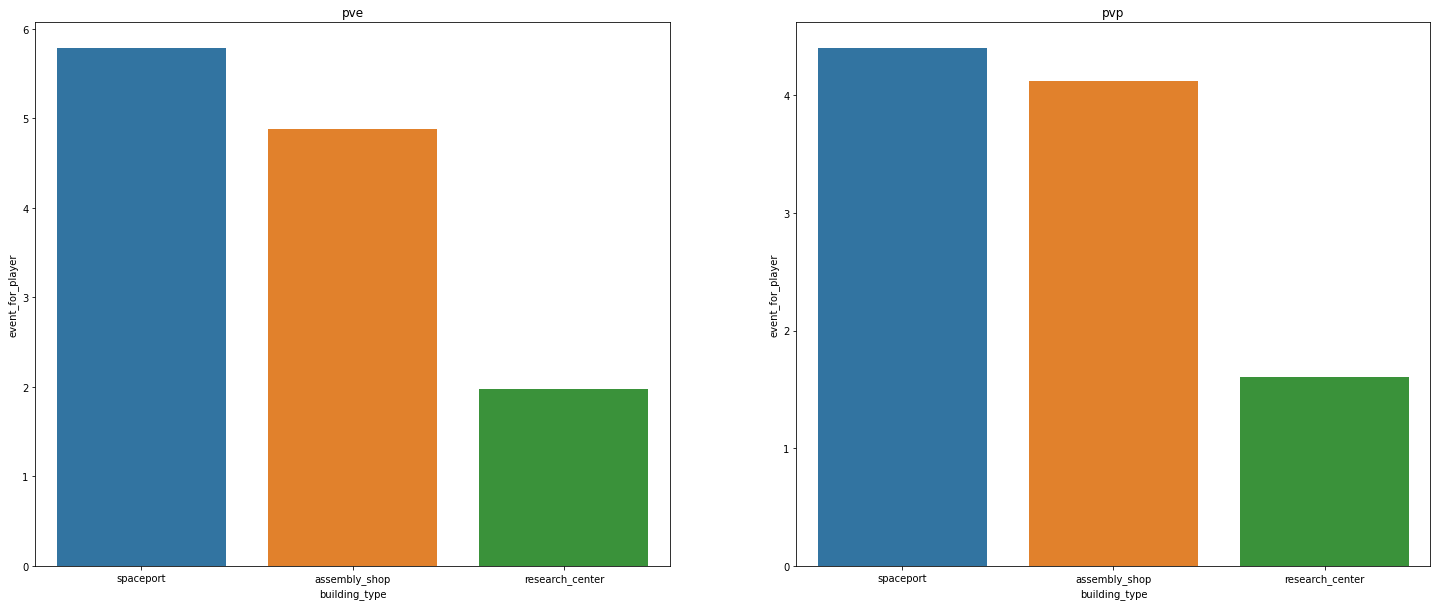

In [115]:
plt.figure(figsize=(25,10))
plt.subplot(1, 2, 1)
sns.barplot(data = pve_bild_count, x='building_type', y='event_for_player')
plt.title('pve')
plt.subplot(1, 2, 2)
sns.barplot(data = pvp_bild_count, x='building_type', y='event_for_player')
plt.title('pvp');

Все игроки много строят,  это значит, что необязательно быть PVE-шером, чтобы смотреть на рекламу в окне строительства. Это часто будут делать и PVP игроки, но также мы видим, что PVE игроки строят здания чаще, чем PVP

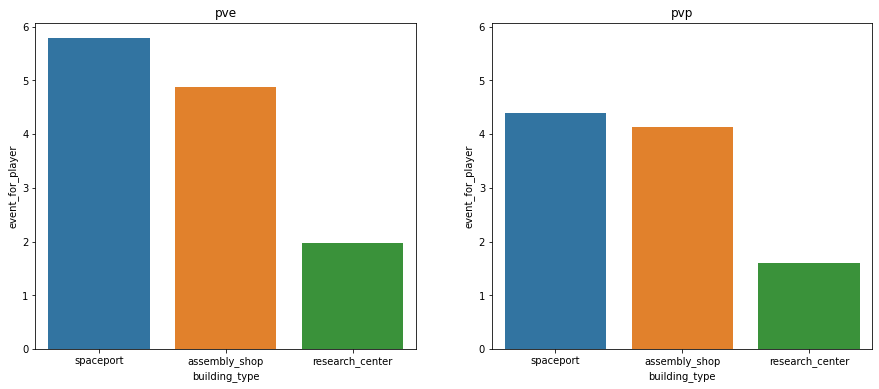

In [119]:


plt.figure(figsize=(15,6))
ax = plt.subplot(1, 2, 1)
sns.barplot(data = pve_bild_count, x='building_type', y='event_for_player')
plt.title('pve')
plt.subplot(1, 2, 2, sharey=ax)
sns.barplot(data = pvp_bild_count, x='building_type', y='event_for_player')
plt.title('pvp');

## PVP VS PVE

посмотрим какие постройки предпочитают игроки разных стилей:


In [57]:
tyt = pve_bild.query('building_type!= "no_building"')
tyt = tyt.groupby('building_type').agg({'event':'count'}).reset_index()
fig = px.pie(tyt, values='event', names='building_type', title='Соотношение построек в игре у ПВЕ игроков')
fig.show()

In [58]:
tyta = pvp_bild.query('building_type!= "no_building"')
tyta = tyta.groupby('building_type').agg({'event':'count'}).reset_index()
fig = px.pie(tyta, values='event', names='building_type', title='Соотношение построек в игре у ПВП игроков')
fig.show()

Интересное наблюдение: PVE игроки чаще строят  исследовательский центр (15,7% от общего числа построек), а PVP-игроки сборочный цех(43%). 

Возможно, в сборочном цехе собираются боевые космолеты? Мы никогда не узнаем...

Давайте добавим к нашему общему датарфейму данные о стиле игры пользователей(Победителей)

In [59]:
pve['pve'] = 1
pve_merge= pve[['user_id','pve']]
pve_merge.head()

user_id  pve
47121  e3c66498-9d45-4000-9392-f81e6796e7da    1
57398  936e7af6-8338-4703-a1df-fc6c3f5b8e34    1
58797  a4491c86-c498-4f74-a56e-65c136d0e9a1    1
61174  85d9e675-562b-4329-8bbd-14d3b39096be    1
63770  1889ca71-3c57-4e61-9ea6-a711971bbf0a    1

In [60]:
pvp['pvp'] = 1
pvp_merge = pvp.groupby(['user_id','pvp']).agg({'day':'count'}).reset_index()
pvp_merge = pvp_merge[['user_id','pvp']]
pvp_merge.head()


user_id  pvp
0  001d39dc-366c-4021-9604-6a3b9ff01e25    1
1  003ee7e8-6356-4286-a715-62f22a18d2a1    1
2  004074f8-251a-4776-922c-8348dca1a2f6    1
3  00464e5e-28ed-4be6-bf44-517ef7b3937b    1
4  0056c007-c082-43cc-bdef-afc49bca4cb9    1

In [61]:
df= df.merge(pvp_merge, on='user_id', how ='left')
df = df.merge(pve_merge, on='user_id', how ='left')
df.head()

user_id        day  event        source  \
0  0001f83c-c6ac-4621-b7f0-8a28b283ac30 2020-05-06     13  facebook_ads   
1  01303c2e-7de1-4742-8c3e-daf182b67b9f 2020-05-06      4  facebook_ads   
2  0136963c-c45c-4edb-92d8-205bd50a4d36 2020-05-06     12  facebook_ads   
3  018793d6-38c8-450a-bd54-8c181d920f1a 2020-05-06     14  facebook_ads   
4  01e2b256-4519-493f-b010-4a90a2755245 2020-05-06      9  facebook_ads   

         cost         first_event          last_event         lifetime  win  \
0  260.185754 2020-05-06 01:07:37 2020-05-20 11:26:06 14 days 10:18:29    0   
1  260.185754 2020-05-06 07:05:11 2020-05-08 22:30:49  2 days 15:25:38    0   
2  260.185754 2020-05-06 14:00:20 2020-05-25 08:56:48 18 days 18:56:28    1   
3  260.185754 2020-05-06 07:05:52 2020-05-24 23:52:53 18 days 16:47:01    1   
4  260.185754 2020-05-06 22:16:07 2020-05-21 04:52:31 14 days 06:36:24    0   

   pvp  pve  
0  NaN  NaN  
1  NaN  NaN  
2  NaN  1.0  
3  NaN  1.0  
4  NaN  NaN

In [62]:
def style(row): # Пишем функцию, чтобы собрать один удобный столбец вместо двух

    pvp = row['pvp']
    pve = row['pve']

    if pvp == 1:
        return 'pvp'

    if pve == 1:
        return 'pve'
    else:
        return 0 # вернем 0, если игрок не переходил на 2 уровень
            

        

    

In [63]:
df['style'] = df.apply(style, axis=1) #Применяем функцию
df

user_id        day  event         source  \
0      0001f83c-c6ac-4621-b7f0-8a28b283ac30 2020-05-06     13   facebook_ads   
1      01303c2e-7de1-4742-8c3e-daf182b67b9f 2020-05-06      4   facebook_ads   
2      0136963c-c45c-4edb-92d8-205bd50a4d36 2020-05-06     12   facebook_ads   
3      018793d6-38c8-450a-bd54-8c181d920f1a 2020-05-06     14   facebook_ads   
4      01e2b256-4519-493f-b010-4a90a2755245 2020-05-06      9   facebook_ads   
...                                     ...        ...    ...            ...   
13571  f904bb06-e8f9-4aef-8773-5a47f12ac103 2020-05-08      5  yandex_direct   
13572  fa1ffc17-0032-4b4d-ac0d-6c75b890db9e 2020-05-08     12  yandex_direct   
13573  fd7d35ce-430b-40e0-a325-9d2b27b425e5 2020-05-08      9  yandex_direct   
13574  fec9a806-0291-4d46-914b-e4dd14ad3864 2020-05-08     10  yandex_direct   
13575  ff77733a-62a1-4d5b-9eb5-034222f24609 2020-05-08      3  yandex_direct   

             cost         first_event          last_event         lifetime  \
0      260.185754 2020-05-06 01:07:37 2020-05-20 11:26:06 14 days 10:18:29   
1      260.185754 2020-05-06 07:05:11 2020-05-08 22:30:49  2 days 15:25:38   
2      260.185754 2020-05-06 14:00:20 2020-05-25 08:56:48 18 days 18:56:28   
3      260.185754 2020-05-06 07:05:52 2020-05-24 23:52:53 18 days 16:47:01   
4      260.185754 2020-05-06 22:16:07 2020-05-21 04:52:31 14 days 06:36:24   
...           ...                 ...                 ...              ...   
13571  114.429338 2020-05-08 15:11:26 2020-05-12 21:07:54  4 days 05:56:28   
13572  114.429338 2020-05-08 06:17:28 2020-05-24 12:50:48 16 days 06:33:20   
13573  114.429338 2020-05-08 23:59:00 2020-05-25 00:18:28 16 days 00:19:28   
13574  114.429338 2020-05-08 23:44:14 2020-05-20 01:25:10 11 days 01:40:56   
13575  114.429338 2020-05-08 22:53:20 2020-05-12 17:19:39  3 days 18:26:19   

       win  pvp  pve style  
0        0  NaN  NaN     0  
1        0  NaN  NaN     0  
2        1  NaN  1.0   pve  
3        1  NaN  1.0   pve  
4        0  NaN  NaN     0  
...    ...  ...  ...   ...  
13571    0  NaN  NaN     0  
13572    1  NaN  1.0   pve  
13573    1  1.0  NaN   pvp  
13574    0  NaN  NaN     0  
13575    0  NaN  NaN     0  

[13576 rows x 12 columns]

In [64]:
df = df.drop(['pvp'], axis=1)#сносим лишние столбцы
df = df.drop(['pve'], axis=1)
df.head()

user_id        day  event        source  \
0  0001f83c-c6ac-4621-b7f0-8a28b283ac30 2020-05-06     13  facebook_ads   
1  01303c2e-7de1-4742-8c3e-daf182b67b9f 2020-05-06      4  facebook_ads   
2  0136963c-c45c-4edb-92d8-205bd50a4d36 2020-05-06     12  facebook_ads   
3  018793d6-38c8-450a-bd54-8c181d920f1a 2020-05-06     14  facebook_ads   
4  01e2b256-4519-493f-b010-4a90a2755245 2020-05-06      9  facebook_ads   

         cost         first_event          last_event         lifetime  win  \
0  260.185754 2020-05-06 01:07:37 2020-05-20 11:26:06 14 days 10:18:29    0   
1  260.185754 2020-05-06 07:05:11 2020-05-08 22:30:49  2 days 15:25:38    0   
2  260.185754 2020-05-06 14:00:20 2020-05-25 08:56:48 18 days 18:56:28    1   
3  260.185754 2020-05-06 07:05:52 2020-05-24 23:52:53 18 days 16:47:01    1   
4  260.185754 2020-05-06 22:16:07 2020-05-21 04:52:31 14 days 06:36:24    0   

  style  
0     0  
1     0  
2   pve  
3   pve  
4     0

Прекрасно, еще один столбец пополнил нашу таблицу уникальных пользователей. 

## Активность в игре

In [65]:
def timeline(x,y): #Функция для отрисовки активности игроков за весь период времени
    times= x.groupby('day').agg({'event':'count'}).reset_index()
    plt.figure(figsize=(12, 7))
    plt.plot(times['day'], times['event'])
    plt.title(y)
    plt.xlabel('время')
    plt.ylabel('Кол-во событий');

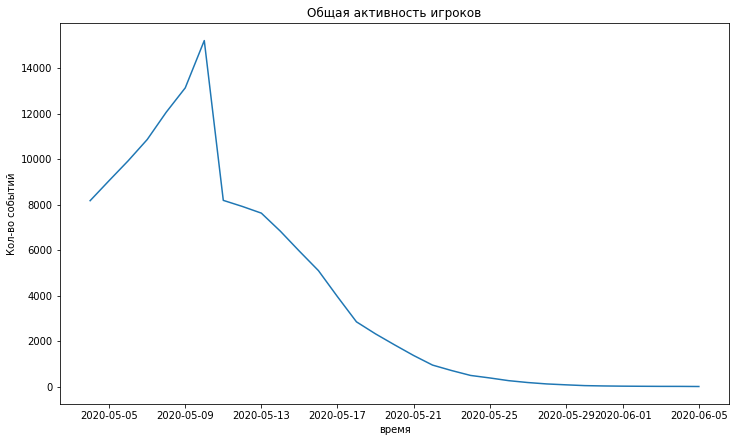

In [66]:
timeline(game_actions,'Общая активность игроков')#Смотрим на картину целиком

Помним, что мы располагаем данными игроков, которые начали пользоваться приложением в период с 4 по 10 мая включительно.
В этот период идет постепенный взлет кол-ва событий, а потом резкое падение - это связано с тем, что средний Лайфтайм игроков 10-11 дней. За этот период плеер либо переходит на второй уровень - либо теряет интерес к игре. 

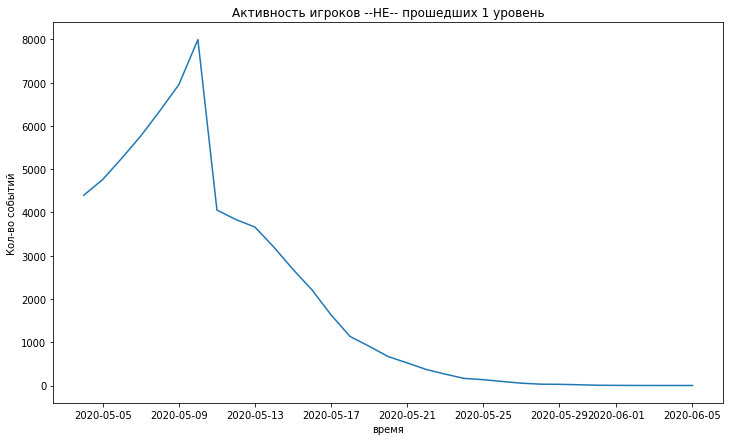

In [67]:
timeline(game_loosers,'Активность игроков --НЕ-- прошедших 1 уровень')#Смотрим на не прошедших 1 лвл

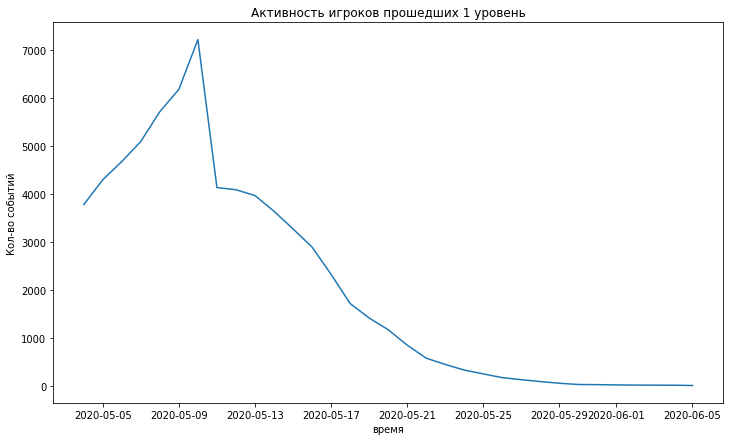

In [68]:
timeline(game_winners,'Активность игроков прошедших 1 уровень')#Смотрим на не прошедших 1 лвл

Картина похожа и там и там, чем дольше игрок находится на первом уровне - тем меньше он строит и интерес к игре пропадает. Это подтверждает наши наблюдения по среднему lifetime пользователя в 10-11 дней. за этот период игрок должен преуспеть, иначе интерес угаснет

Интересно, позволяет ли игра играть дальше после реализации условий победы:

In [69]:
game_actions.query('project_type!=0 ')

event_datetime    event building_type  \
47121  2020-05-08 18:10:25  project   no_building   
57398  2020-05-09 13:49:11  project   no_building   
58797  2020-05-09 16:19:33  project   no_building   
61174  2020-05-09 20:29:01  project   no_building   
63770  2020-05-10 00:57:47  project   no_building   
...                    ...      ...           ...   
135601 2020-06-02 03:04:42  project   no_building   
135602 2020-06-02 06:21:03  project   no_building   
135608 2020-06-02 17:17:28  project   no_building   
135616 2020-06-03 09:46:04  project   no_building   
135629 2020-06-04 08:29:42  project   no_building   

                                     user_id                project_type  \
47121   e3c66498-9d45-4000-9392-f81e6796e7da  satellite_orbital_assembly   
57398   936e7af6-8338-4703-a1df-fc6c3f5b8e34  satellite_orbital_assembly   
58797   a4491c86-c498-4f74-a56e-65c136d0e9a1  satellite_orbital_assembly   
61174   85d9e675-562b-4329-8bbd-14d3b39096be  satellite_orbital_assembly   
63770   1889ca71-3c57-4e61-9ea6-a711971bbf0a  satellite_orbital_assembly   
...                                      ...                         ...   
135601  9d98001c-7e14-40d7-896e-46b3047365fd  satellite_orbital_assembly   
135602  df4a1e13-eba9-4928-a7cf-ee303d6f80f9  satellite_orbital_assembly   
135608  82e46f34-e243-4728-8e20-2e171fc33ea4  satellite_orbital_assembly   
135616  fe032991-71e0-48c5-889f-4c3805ba4c9b  satellite_orbital_assembly   
135629  d477dde8-7c22-4f23-9c4f-4ec31a1aa4c8  satellite_orbital_assembly   

              day  
47121  2020-05-08  
57398  2020-05-09  
58797  2020-05-09  
61174  2020-05-09  
63770  2020-05-10  
...           ...  
135601 2020-06-02  
135602 2020-06-02  
135608 2020-06-02  
135616 2020-06-03  
135629 2020-06-04  

[1866 rows x 6 columns]

In [70]:
game_actions.query('user_id =="1889ca71-3c57-4e61-9ea6-a711971bbf0a" ')#Случайно проверим пользователя.

event_datetime             event    building_type  \
473    2020-05-04 01:27:10          building    assembly_shop   
11179  2020-05-05 08:13:58          building    assembly_shop   
13354  2020-05-05 14:01:22          building    assembly_shop   
19986  2020-05-06 06:51:27          building    assembly_shop   
20947  2020-05-06 09:12:14          building    assembly_shop   
44680  2020-05-08 13:21:44          building        spaceport   
47998  2020-05-08 19:57:32          building        spaceport   
49375  2020-05-08 22:41:43          building  research_center   
50061  2020-05-08 23:58:56          building    assembly_shop   
61959  2020-05-09 21:52:20          building        spaceport   
63770  2020-05-10 00:57:47           project      no_building   
69655  2020-05-10 10:36:26          building    assembly_shop   
76313  2020-05-10 20:50:56          building  research_center   
90451  2020-05-12 11:36:36          building        spaceport   
110052 2020-05-15 04:13:18          building  research_center   
111501 2020-05-15 09:43:50  finished_stage_1      no_building   

                                     user_id                project_type  \
473     1889ca71-3c57-4e61-9ea6-a711971bbf0a                           0   
11179   1889ca71-3c57-4e61-9ea6-a711971bbf0a                           0   
13354   1889ca71-3c57-4e61-9ea6-a711971bbf0a                           0   
19986   1889ca71-3c57-4e61-9ea6-a711971bbf0a                           0   
20947   1889ca71-3c57-4e61-9ea6-a711971bbf0a                           0   
44680   1889ca71-3c57-4e61-9ea6-a711971bbf0a                           0   
47998   1889ca71-3c57-4e61-9ea6-a711971bbf0a                           0   
49375   1889ca71-3c57-4e61-9ea6-a711971bbf0a                           0   
50061   1889ca71-3c57-4e61-9ea6-a711971bbf0a                           0   
61959   1889ca71-3c57-4e61-9ea6-a711971bbf0a                           0   
63770   1889ca71-3c57-4e61-9ea6-a711971bbf0a  satellite_orbital_assembly   
69655   1889ca71-3c57-4e61-9ea6-a711971bbf0a                           0   
76313   1889ca71-3c57-4e61-9ea6-a711971bbf0a                           0   
90451   1889ca71-3c57-4e61-9ea6-a711971bbf0a                           0   
110052  1889ca71-3c57-4e61-9ea6-a711971bbf0a                           0   
111501  1889ca71-3c57-4e61-9ea6-a711971bbf0a                           0   

              day  
473    2020-05-04  
11179  2020-05-05  
13354  2020-05-05  
19986  2020-05-06  
20947  2020-05-06  
44680  2020-05-08  
47998  2020-05-08  
49375  2020-05-08  
50061  2020-05-08  
61959  2020-05-09  
63770  2020-05-10  
69655  2020-05-10  
76313  2020-05-10  
90451  2020-05-12  
110052 2020-05-15  
111501 2020-05-15

Судя по всему даже после разработки орбитальной сборки спутников - игрок может продолжить играть на первом уровне и нажать кнопку перехода спустя какое-то время. ПО PVP игрокам такое отследить не получится, т.к. у нас нет данных о победе, только о нажатии кнопки

## Выводы

Итак, мы имеем финальный датафрейм со всеми необходимыми данными. В ходе анализа поведения игроков мы выяснили:
- Лайфтайм игроков, которые НЕ проходят на второй уровень длится 9 с половиной дней(медианно)
- Лайфтайм игроков, которые проходят на второй уровень длится 11 с половиной дней(медианно)
- Чаще всего игроки предпочитают строить здание типа космопорт(46.4%), потом  сборочный цех(42.6%), а вот  исследовательский центр строят очень редко, всего 11% от всех построек в игре.
- Из 13576 игроков, установивших приложение - на второй уровень перешли 5817(42%) - это зона Роста
- Из победителей у 1866(32%) были построены орбитальные сборки спутников, а 3951(68%) завершили игроку без этой постройки, а значит за победу над перым игроков. Т.е. 68% игроков предпочитают PVP, а 32 - PVE
-  PVE игроки чаще строят  исследовательский центр, а PVP-игроки сборочный цех. 
- ***PVE игроки строят больше, чем PVP***
- Максимальная активность была с 4 по 10 мая(время рекламы), а потом стремительно снижалась
    

# Анализ эффективности рекламных источников

In [71]:
sources = ad_cost.groupby('source').agg({'cost':'sum'}).reset_index().sort_values(by='cost',ascending=False)


In [72]:
fig = px.pie(sources, values='cost', names='source', title='Траты рекламного бюджета по источникам')
fig.show()

Топ трат по источникам: 

1) ***yandex_direct:***	2233

2) ***instagram_new_adverts:***	2161

3) ***facebook_ads:***	2140

4) ***youtube_channel_reklama:***	1068


youtube_channel_reklama затратил меньше всего финансов, остальные источники примерно равны

In [73]:
count_users = df.groupby('source').agg({'user_id':'nunique'}).reset_index().sort_values(by='user_id', ascending=False)
count_users

source  user_id
2            yandex_direct     4817
1    instagram_new_adverts     3347
0             facebook_ads     2726
3  youtube_channel_reklama     2686

In [74]:
fig = px.pie(count_users, values='user_id', names='source', title='Доли привлеченных пользователей по источникам')
fig.show()

Больше всего пользователей привлек yandex_direct: 4817(35%), меньше всего - youtube_channel_reklama: 2686(19,8%)

In [75]:
for_1_user= count_users.merge(sources, how='inner',on='source')
for_1_user['price_for_1'] = for_1_user['cost']/for_1_user['user_id'] 
for_1_user = for_1_user.sort_values(by='price_for_1',ascending=False)
for_1_user

source  user_id         cost  price_for_1
2             facebook_ads     2726  2140.904643     0.785365
1    instagram_new_adverts     3347  2161.441691     0.645785
0            yandex_direct     4817  2233.111449     0.463590
3  youtube_channel_reklama     2686  1068.119204     0.397662

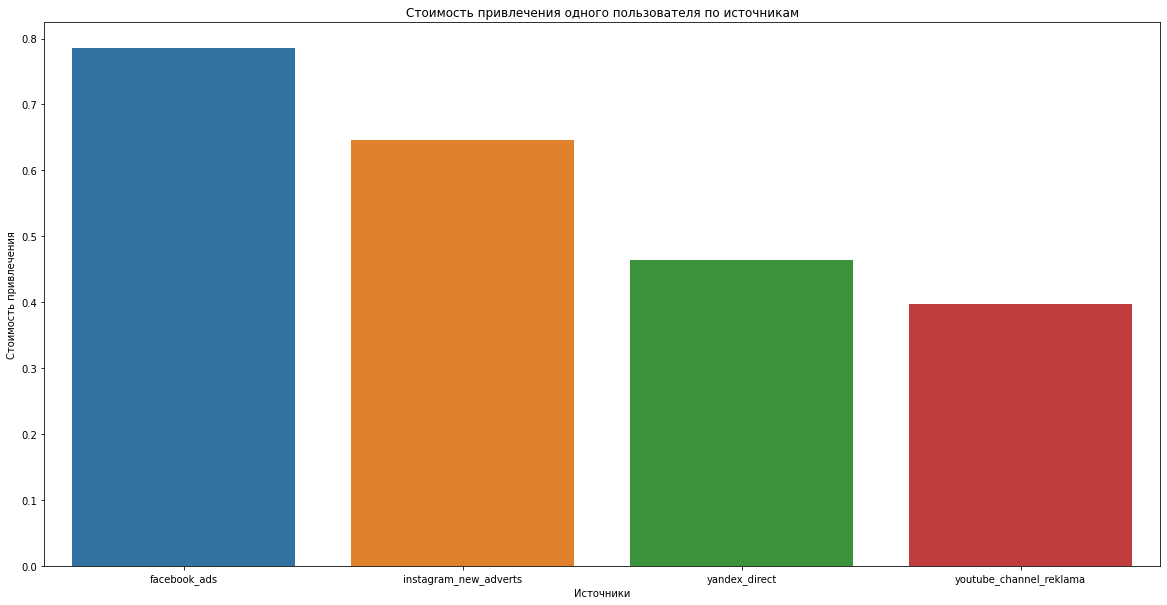

In [76]:
plt.figure(figsize=(20,10))
sns.barplot(data = for_1_user, x='source', y='price_for_1')
plt.title('Cтоимость привлечения одного пользователя по источникам')
plt.xlabel('Источники')
plt.ylabel('Стоимость привлечения');

Дороже всего выходит facebook_ads (0.78 - за игрока)

на 2 месте instagram_new_adverts (0.64 - за игрока)

yandex_direct и youtube_channel_reklama значительно дешевле (0.46 и 0.39)


***Важно понимать, отличается ли поведение пользователей в зависимости от рекламных источников, возможно где-то они больше строят или больше выигрывают*** 

In [77]:
df_2 = df[['user_id', 'day', 'source', 'cost', 'lifetime', 'win', 'style']] #Собираем датафрейм с активностями 
df_2 = df_2.merge(game_actions, how = 'outer', on = 'user_id')
df_2=df_2.rename(columns= {'day_y':'all_day','day_x':'mark_day'})
df_2.head()

user_id   mark_day        source        cost  \
0  0001f83c-c6ac-4621-b7f0-8a28b283ac30 2020-05-06  facebook_ads  260.185754   
1  0001f83c-c6ac-4621-b7f0-8a28b283ac30 2020-05-06  facebook_ads  260.185754   
2  0001f83c-c6ac-4621-b7f0-8a28b283ac30 2020-05-06  facebook_ads  260.185754   
3  0001f83c-c6ac-4621-b7f0-8a28b283ac30 2020-05-06  facebook_ads  260.185754   
4  0001f83c-c6ac-4621-b7f0-8a28b283ac30 2020-05-06  facebook_ads  260.185754   

          lifetime  win style      event_datetime     event  building_type  \
0 14 days 10:18:29    0     0 2020-05-06 01:07:37  building  assembly_shop   
1 14 days 10:18:29    0     0 2020-05-06 11:31:56  building  assembly_shop   
2 14 days 10:18:29    0     0 2020-05-06 15:11:50  building  assembly_shop   
3 14 days 10:18:29    0     0 2020-05-09 05:59:57  building  assembly_shop   
4 14 days 10:18:29    0     0 2020-05-09 07:35:40  building  assembly_shop   

  project_type    all_day  
0            0 2020-05-06  
1            0 2020-05-06  
2            0 2020-05-06  
3            0 2020-05-09  
4            0 2020-05-09

In [78]:
even_for_1 = df_2.groupby('source').agg({'user_id':'nunique','event':'count'}).reset_index()
even_for_1['event_for_1'] = even_for_1['event'] /even_for_1['user_id']
even_for_1




source  user_id  event  event_for_1
0             facebook_ads     2726  27672    10.151137
1    instagram_new_adverts     3347  33757    10.085748
2            yandex_direct     4817  47694     9.901183
3  youtube_channel_reklama     2686  26516     9.871929

In [79]:
df_2.query('source =="facebook_ads"')['lifetime'].median()

Timedelta('11 days 12:27:50')

In [80]:
df_2.query('source =="instagram_new_adverts"')['lifetime'].median()

Timedelta('11 days 12:34:08')

In [81]:
df_2.query('source =="yandex_direct"')['lifetime'].median()

Timedelta('11 days 09:20:33')

In [82]:
df_2.query('source =="youtube_channel_reklama"')['lifetime'].median()

Timedelta('11 days 12:17:53')

Разница в активности пользователей по рекламным источникам незначительна, игроки со всех источников совершают примерно одинаковое кол-во ивентов за свое время в игре. Время вы игре, кстати, тоже отличается незначительно,медианно, все игроки живут 11 дней. 


Возможно, в каком-то источнике больше процент побед?

In [83]:
winrate = df.groupby('source').agg({'win':'sum', 'user_id':'nunique'}).reset_index()
winrate['win_procent'] = winrate['win'] / winrate['user_id'] * 100 
winrate

source   win  user_id  win_procent
0             facebook_ads  1150     2726    42.186354
1    instagram_new_adverts  1466     3347    43.800418
2            yandex_direct  2042     4817    42.391530
3  youtube_channel_reklama  1159     2686    43.149665

Винрейт тоже стабилен у всех пользователей - от 42 до 43 процентов, канал привлечения здесь не влияет. 

Посмотрим на стиль игры: 

In [84]:
style = df_2.query('style !=0')
style = style.groupby(['user_id', 'style','source']).agg({'win':'count'}).reset_index()
style_pvp = style.query('style == "pvp"')
style_pve = style.query('style == "pve"')
style_pve = style_pve.groupby('source').agg({'style': 'count'}).reset_index()
style_pve = style_pve.rename(columns={'style':'pve'})
style_pvp = style_pvp.groupby('source').agg({'style': 'count'}).reset_index()
style_pvp = style_pvp.rename(columns={'style':'pvp'})
style_all = style.groupby('source').agg({'user_id':'count'})
style_all = style_all.merge(style_pvp, how='inner', on='source')
style_all = style_all.merge(style_pve, how='inner', on='source')
style_all['pvp_procent'] = style_all['pvp'] / style_all['user_id'] *100
style_all

source  user_id   pvp  pve  pvp_procent
0             facebook_ads     1150   759  391    66.000000
1    instagram_new_adverts     1466   990  476    67.530696
2            yandex_direct     2042  1422  620    69.637610
3  youtube_channel_reklama     1159   780  379    67.299396

Процент PVP игроков колеблется от 66 до 69, в зависимости от истичника. Игроки пришедшие с яндекс предпочитают PVP чуть больше остальных. Однако пара отличие в несколько процентов мы серьезным не считаем, следовательно, игроки с разных источников +- одинаково ПВПшат и ПВЕшат

## Анализ рекламных источников по дням 

In [85]:
df_2_grouped = df_2.groupby(['mark_day', 'source', 'cost']).agg({'event_datetime':'count','user_id':'nunique' }).reset_index()
df_2_grouped['price_for_one_user'] = df_2_grouped['cost'] / df_2_grouped['user_id'] 
df_2_grouped['events_for_one_user'] = df_2_grouped['event_datetime'] / df_2_grouped['user_id'] #Группируем и добавляем колонки
df_2_grouped.head()

mark_day                   source        cost  event_datetime  user_id  \
0 2020-05-04             facebook_ads  935.882786           13222     1184   
1 2020-05-04    instagram_new_adverts  943.204717           16063     1452   
2 2020-05-04            yandex_direct  969.139394           22436     2078   
3 2020-05-04  youtube_channel_reklama  454.224943           12505     1146   
4 2020-05-05             facebook_ads  548.354480            7311      694   

   price_for_one_user  events_for_one_user  
0            0.790442            11.167230  
1            0.649590            11.062672  
2            0.466381            10.796920  
3            0.396357            10.911867  
4            0.790136            10.534582

Разобьем данные по источникам:

In [86]:
fb = df_2_grouped.query('source == "facebook_ads"')
fb

mark_day        source        cost  event_datetime  user_id  \
0  2020-05-04  facebook_ads  935.882786           13222     1184   
4  2020-05-05  facebook_ads  548.354480            7311      694   
8  2020-05-06  facebook_ads  260.185754            3264      345   
12 2020-05-07  facebook_ads  177.982200            1894      224   
16 2020-05-08  facebook_ads  111.766796            1009      139   
20 2020-05-09  facebook_ads   68.009276             639       84   
24 2020-05-10  facebook_ads   38.723350             333       56   

    price_for_one_user  events_for_one_user  
0             0.790442            11.167230  
4             0.790136            10.534582  
8             0.754162             9.460870  
12            0.794563             8.455357  
16            0.804078             7.258993  
20            0.809634             7.607143  
24            0.691488             5.946429

In [87]:
insta =df_2_grouped.query('source == "instagram_new_adverts"')
insta

mark_day                 source        cost  event_datetime  user_id  \
1  2020-05-04  instagram_new_adverts  943.204717           16063     1452   
5  2020-05-05  instagram_new_adverts  502.925451            8275      796   
9  2020-05-06  instagram_new_adverts  313.970984            4477      472   
13 2020-05-07  instagram_new_adverts  173.071145            2388      270   
17 2020-05-08  instagram_new_adverts  109.915254            1354      175   
21 2020-05-09  instagram_new_adverts   71.578739             774      112   
25 2020-05-10  instagram_new_adverts   46.775400             426       70   

    price_for_one_user  events_for_one_user  
1             0.649590            11.062672  
5             0.631816            10.395729  
9             0.665193             9.485169  
13            0.641004             8.844444  
17            0.628087             7.737143  
21            0.639096             6.910714  
25            0.668220             6.085714

In [88]:
ya = df_2_grouped.query('source == "yandex_direct"')
ya

mark_day         source        cost  event_datetime  user_id  \
2  2020-05-04  yandex_direct  969.139394           22436     2078   
6  2020-05-05  yandex_direct  554.651494           12365     1208   
10 2020-05-06  yandex_direct  308.232990            6244      664   
14 2020-05-07  yandex_direct  180.917099            3409      395   
18 2020-05-08  yandex_direct  114.429338            1742      239   
22 2020-05-09  yandex_direct   62.961630             912      144   
26 2020-05-10  yandex_direct   42.779505             586       89   

    price_for_one_user  events_for_one_user  
2             0.466381            10.796920  
6             0.459149            10.235927  
10            0.464206             9.403614  
14            0.458018             8.630380  
18            0.478784             7.288703  
22            0.437234             6.333333  
26            0.480669             6.584270

In [89]:
you = df_2_grouped.query('source == "youtube_channel_reklama"')
you

mark_day                   source        cost  event_datetime  user_id  \
3  2020-05-04  youtube_channel_reklama  454.224943           12505     1146   
7  2020-05-05  youtube_channel_reklama  259.073224            6805      663   
11 2020-05-06  youtube_channel_reklama  147.041741            3414      366   
15 2020-05-07  youtube_channel_reklama   88.506074            1738      220   
19 2020-05-08  youtube_channel_reklama   55.740645            1016      135   
23 2020-05-09  youtube_channel_reklama   40.217907             700      100   
27 2020-05-10  youtube_channel_reklama   23.314669             338       56   

    price_for_one_user  events_for_one_user  
3             0.396357            10.911867  
7             0.390759            10.263952  
11            0.401753             9.327869  
15            0.402300             7.900000  
19            0.412894             7.525926  
23            0.402179             7.000000  
27            0.416333             6.035714

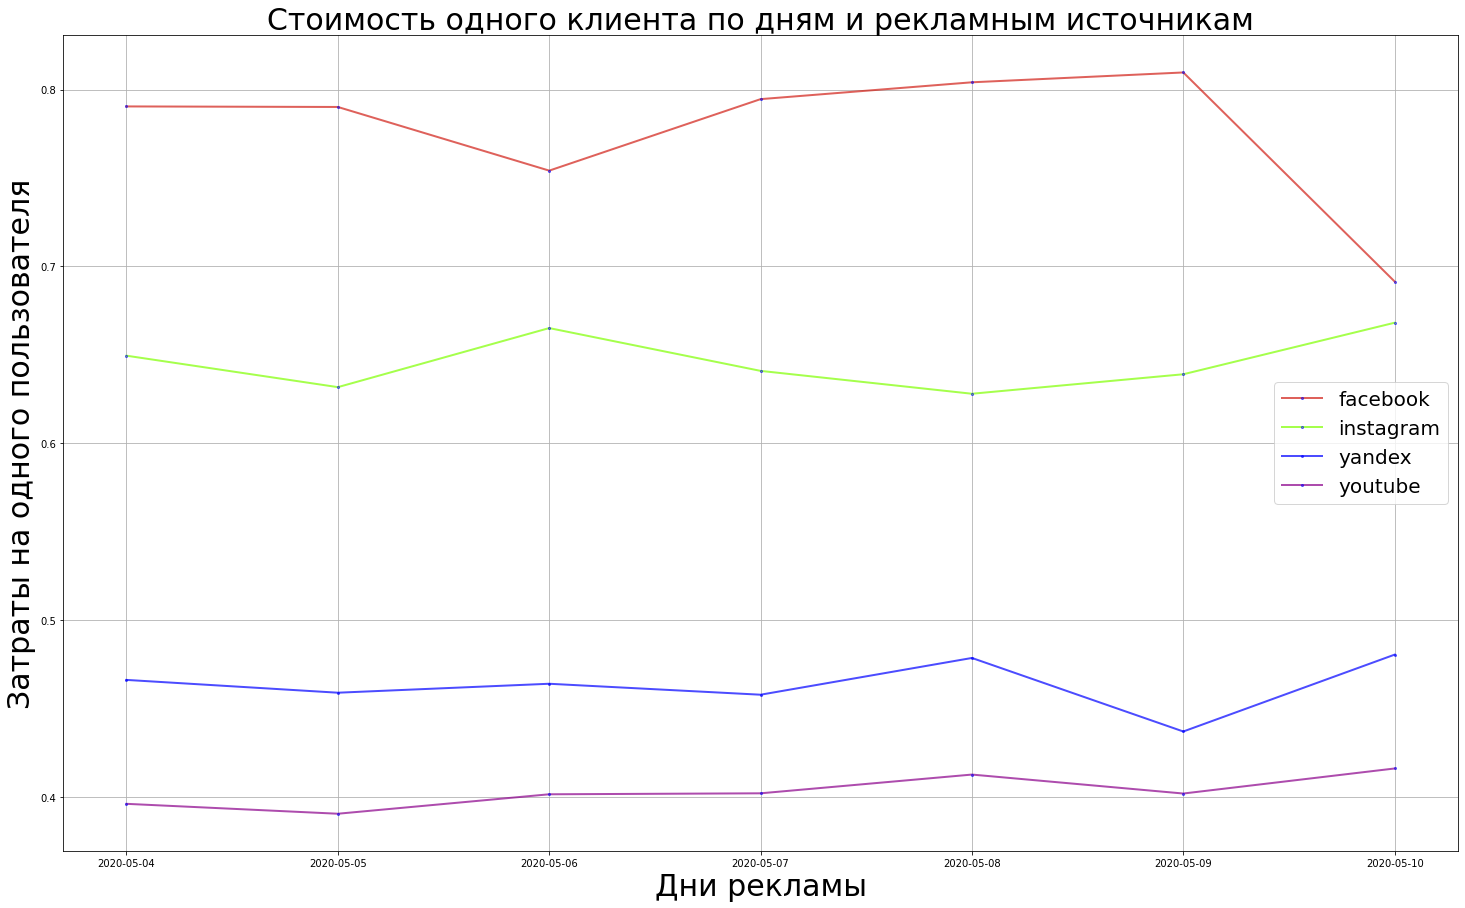

In [90]:
plt.figure(figsize=(25, 15))
plt.plot(fb['mark_day'], fb['price_for_one_user'], 'o-r', alpha=0.7, label="facebook", lw=2, mec='b', mew=2, ms=1,color = '#d11e15')
plt.plot(insta['mark_day'], insta['price_for_one_user'], 'o-r', alpha=0.7, label="instagram", lw=2, mec='b', mew=2, ms=1,color = '#7FFF00')
plt.plot(ya['mark_day'], ya['price_for_one_user'], 'o-r', alpha=0.7, label="yandex", lw=2, mec='b', mew=2, ms=1,color = '#0000FF')
plt.plot(you['mark_day'], you['price_for_one_user'], 'o-r', alpha=0.7, label="youtube", lw=2, mec='b', mew=2, ms=1,color = '#8B008B')
plt.xlabel('Дни рекламы',size=30)
plt.ylabel('Затраты на одного пользователя',size=30)
plt.title('Стоимость одного клиента по дням и рекламным источникам',size=30)
plt.legend(fontsize = 20)
plt.grid(True)
plt.show();

Выводы выше подтверждаются, самыми дешевыми источниками являются youtube_channel_reklama  и yandex_direct, facebook_ads и instagram_new_adverts получаются значительно дороже

Посмотрим на активность юзеров в зависимости от рекламных источников: 

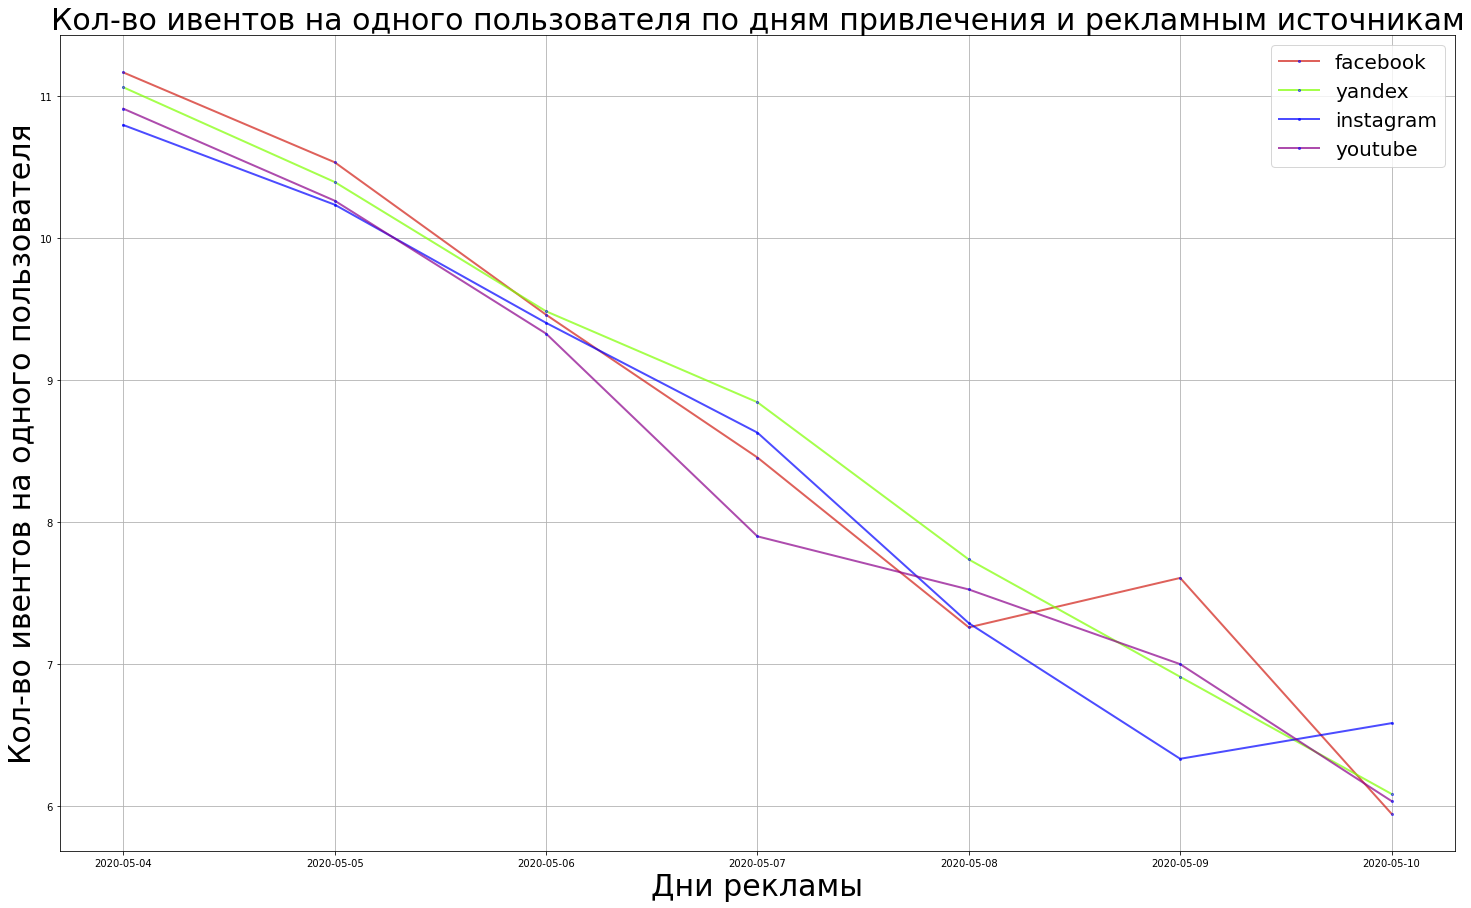

In [91]:
plt.figure(figsize=(25, 15))
plt.plot(fb['mark_day'], fb['events_for_one_user'], 'o-r', alpha=0.7, label="facebook", lw=2, mec='b', mew=2, ms=1,color = '#d11e15')
plt.plot(insta['mark_day'], insta['events_for_one_user'], 'o-r', alpha=0.7, label="yandex", lw=2, mec='b', mew=2, ms=1,color = '#7FFF00')
plt.plot(ya['mark_day'], ya['events_for_one_user'], 'o-r', alpha=0.7, label="instagram", lw=2, mec='b', mew=2, ms=1,color = '#0000FF')
plt.plot(you['mark_day'], you['events_for_one_user'], 'o-r', alpha=0.7, label="youtube", lw=2, mec='b', mew=2, ms=1,color = '#8B008B')
plt.xlabel('Дни рекламы',size=30)
plt.ylabel('Кол-во ивентов на одного пользователя',size=30)
plt.title('Кол-во ивентов на одного пользователя по дням привлечения и рекламным источникам',size=30)
plt.legend(fontsize = 20)
plt.grid(True)
plt.show();

Активность пользователей +- стабильна у всех, разве что yandex показывает себя чуть лучше и стабильнее.

Давайте посмотрим на активность в весь период жизни пользователей:

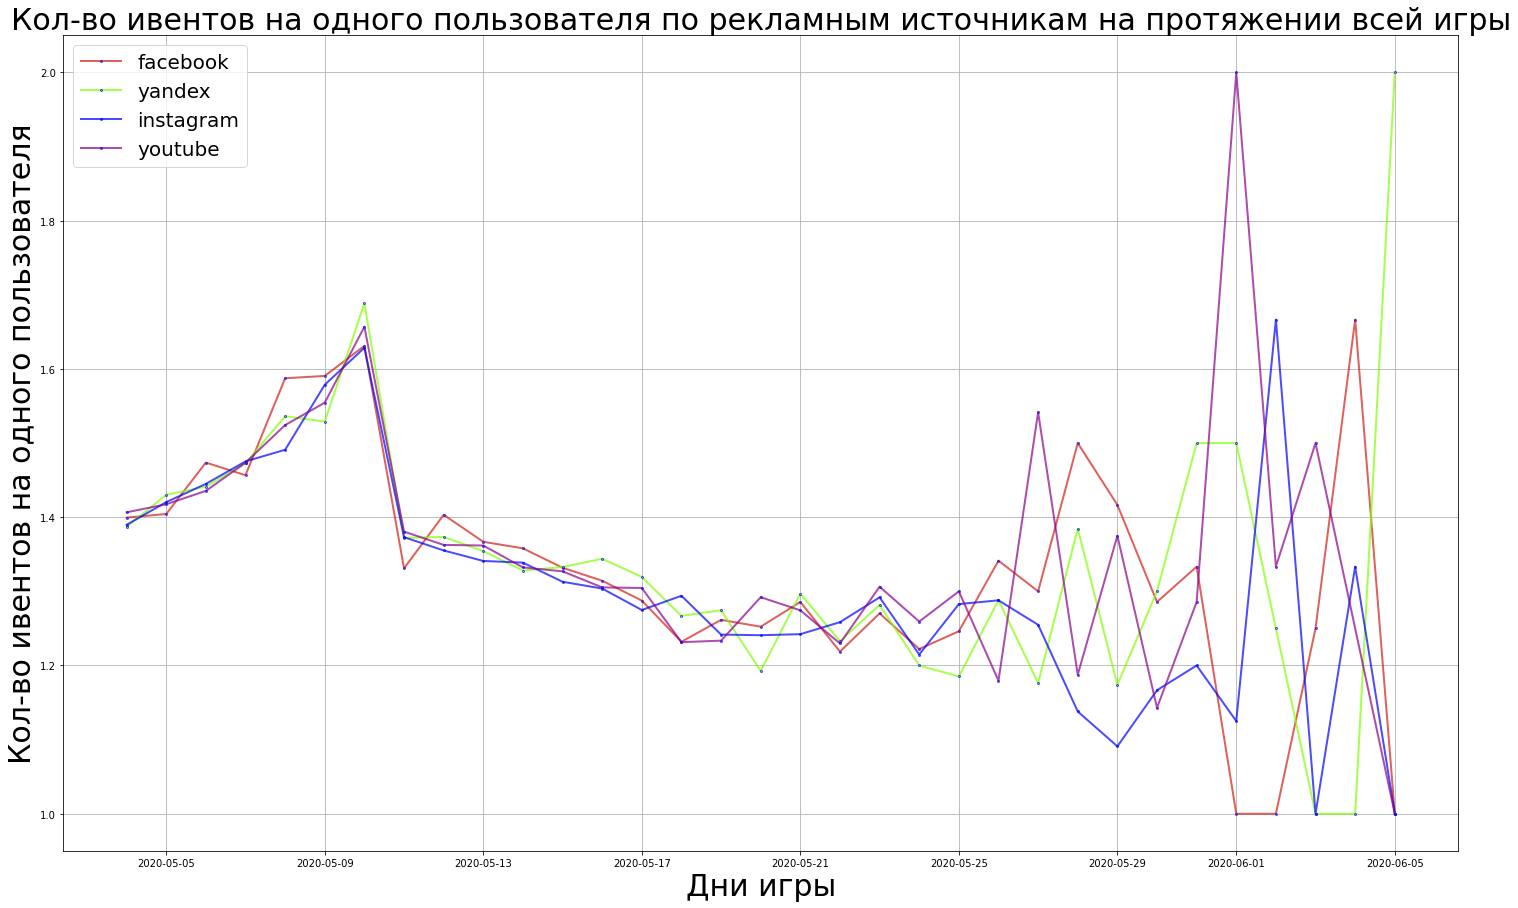

In [92]:
facebook = df_2.query('source == "facebook_ads"')
instagramm =df_2.query('source == "instagram_new_adverts"')
yandex = df_2.query('source == "yandex_direct"')
youtube = df_2.query('source == "youtube_channel_reklama"')


facebook = facebook.groupby('all_day').agg({'event':'count','user_id':'nunique'}).reset_index()
facebook['for_1_user'] = facebook['event'] / facebook['user_id']

instagramm = instagramm.groupby('all_day').agg({'event':'count','user_id':'nunique'}).reset_index()
instagramm['for_1_user'] = instagramm['event'] / instagramm['user_id']


yandex = yandex.groupby('all_day').agg({'event':'count','user_id':'nunique'}).reset_index()
yandex['for_1_user'] = yandex['event'] / yandex['user_id']


youtube = youtube.groupby('all_day').agg({'event':'count','user_id':'nunique'}).reset_index()
youtube['for_1_user'] = youtube['event'] / youtube['user_id']

plt.figure(figsize=(25, 15))
plt.plot(facebook['all_day'], facebook['for_1_user'], 'o-r', alpha=0.7, label="facebook", lw=2, mec='b', mew=2, ms=1,color = '#d11e15')
plt.plot(instagramm['all_day'], instagramm['for_1_user'], 'o-r', alpha=0.7, label="yandex", lw=2, mec='b', mew=2, ms=1,color = '#7FFF00')
plt.plot(yandex['all_day'], yandex['for_1_user'], 'o-r', alpha=0.7, label="instagram", lw=2, mec='b', mew=2, ms=1,color = '#0000FF')
plt.plot(youtube['all_day'], youtube['for_1_user'], 'o-r', alpha=0.7, label="youtube", lw=2, mec='b', mew=2, ms=1,color = '#8B008B')

plt.xlabel('Дни игры',size=30)
plt.ylabel('Кол-во ивентов на одного пользователя',size=30)
plt.title('Кол-во ивентов на одного пользователя по рекламным источникам на протяжении всей игры',size=30)
plt.legend(fontsize = 20)
plt.grid(True)
plt.show();

ЗДесь картина тоже не сильно отличается, значит мы можем сделать вывод, что качество и активность игроков НЕ отличаются в зависимости от источников 

## Выводы

Мы проанализировали 4 источника привлечения клиентов. 

По результатам анализа можем сделать заявление, что ***Поведение и качество пользователей НЕ зависит от типа источника привлечения, все пользователи ведут себя +- равно, а это значит, что нужно сделать акцент на стоимость рекламы и кол-во привлеченных клиентов.***

Все пользователи имеют примерно одинаковые показатели:
- Процент PVP игроков от 66-69
- Равное кол-во ивентов около 10 
- Винрейт 42-43 процента
- Лайфтайм в 10 с половиной дней. 


Топ трат по источникам привлечения клиентов: 

1) ***yandex_direct:***	2233

2) ***instagram_new_adverts:***	2161

3) ***facebook_ads:***	2140

4) ***youtube_channel_reklama:***	1068

Топ Привлеченных клиентов: 

1)  ***yandex_direct:***	4817

2) 	***instagram_new_adverts:***	3347

3) 	***facebook_ads	2726:***

4) 	***youtube_channel_reklama:***	2686


Если мы говорим о стоимости за 1 привлеченный лид: 

- Дороже всего выходит facebook_ads (0.78 - за игрока)

- на 2 месте instagram_new_adverts (0.64 - за игрока)

- yandex_direct и youtube_channel_reklama значительно дешевле (0.46 и 0.39)


Учитывая тот факт, что ***пользователи не отличаются по своему качеству***, можно сделать рекомендации для отдела маркетинга: 

- Направить силы рекламных компаний на  youtube_channel_reklama и yandex_direct, т.к. youtube_channel_reklama дает нам самых дешевых пользователей, а yandex_direct дает самое больший поток клиентов, по не самой высокой цене. 

- Снизить расходы на instagram_new_adverts и facebook_ads, т.к. эти каналы выходят неприемлемо дорогими на фоне своих конкурентов. 



# Проверяем статистические гипотезы

## Проверяем гипотезу №1: 
Время завершения уровня различается в зависимости способа прохождения:

- *через реализацию проекта*

- *через победу над первым игроком.*

In [93]:
pvp_df = df.query('style =="pvp"') #Возьмем данные
pve_df = df.query('style =="pve"') 

In [94]:
pvp_df['lifetime'] #дата нам не подходит, возьмем int

7       12 days 14:11:47
8        7 days 18:32:48
13       7 days 12:03:51
15       7 days 00:52:51
17       6 days 21:32:14
              ...       
13560    8 days 03:01:24
13561    4 days 06:29:16
13563    1 days 20:49:12
13565    5 days 05:29:17
13573   16 days 00:19:28
Name: lifetime, Length: 3951, dtype: timedelta64[ns]

In [95]:
pvp_df['days_lifetime'] = pvp_df['lifetime'].dt.days
pve_df['days_lifetime'] = pve_df['lifetime'].dt.days

In [96]:
pve_df.info() #Успех

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1866 entries, 2 to 13572
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   user_id        1866 non-null   object         
 1   day            1866 non-null   datetime64[ns] 
 2   event          1866 non-null   int64          
 3   source         1866 non-null   object         
 4   cost           1866 non-null   float64        
 5   first_event    1866 non-null   datetime64[ns] 
 6   last_event     1866 non-null   datetime64[ns] 
 7   lifetime       1866 non-null   timedelta64[ns]
 8   win            1866 non-null   int64          
 9   style          1866 non-null   object         
 10  days_lifetime  1866 non-null   int64          
dtypes: datetime64[ns](3), float64(1), int64(3), object(3), timedelta64[ns](1)
memory usage: 174.9+ KB


In [97]:
print(len(pve_df['days_lifetime']))
print(len(pvp_df['days_lifetime']))

1866
3951


И так, у нас есть два нужны столбца со временем прохождения игры разными стилями.
Проверим нормальность распределения

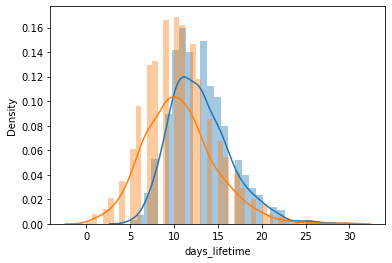

In [98]:
sns.distplot(pve_df['days_lifetime']);
sns.distplot(pvp_df['days_lifetime']);


Проверка при помощи QQ-графиков

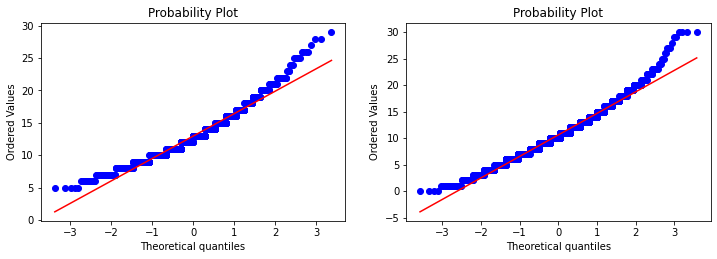

In [99]:
# строим qq-plot для нормального распределения
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
st.probplot(pve_df['days_lifetime'], dist="norm", plot=plt)
plt.subplot(2,2,2)
st.probplot(pvp_df['days_lifetime'], dist="norm", plot=plt)
plt.show()

Распределение случайных величин немного отличается от нормального + у нас разные размеры выборок, давайте проведем Непараметрический тест Манна-Уитни, он более устойчив в выбросам(а мы помним, что есть игроки, которые проходили 1 уровень целый месяц)

Введем основную и альтернативные гипотезы:


   H_0 Время прохождения 1 уровня пользователей  PVE и PVP одинаковое
   
   H_1 Время прохождения 1 уровня пользователей  PVE и PVP отличается

Уровень значимости: alpha = 0.05$

Если p-value будет меньше выбранного уровня значимости $\alpha = 0.05$, то нулевую гипотезу о равенстве средних отвергнем. Иначе сделаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.

In [100]:
alpha = 0.05
results = st.mannwhitneyu(pve_df['days_lifetime'], pvp_df['days_lifetime'], alternative='two-sided')
print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  1.4810402498079134e-105
Отвергаем нулевую гипотезу



Мы отвергаем нулевую гипотезу в пользу альтернативной: 
"Время прохождения 1 уровня пользователей  PVE и PVP отличается"




Односторонняя проверка:

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Время прохождения 1 уровня пользователей  PVE и PVP одинаковое}\\
   H_1 :\text{Время прохождения 1 уровня у пользователей  PVE больше чем у PVP}
 \end{cases}
\end{equation*}$

In [101]:
results = st.mannwhitneyu(pve_df['days_lifetime'], pvp_df['days_lifetime'], alternative='greater')
print('p-значение: ', results.pvalue)
print(alpha)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  7.405201249039567e-106
0.05
Отвергаем нулевую гипотезу


Еще проверочка

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Время прохождения 1 уровня пользователей  PVE и PVP одинаковое}\\
   H_1 :\text{Время прохождения 1 уровня у пользователей  PVE меньше чем у PVP}
 \end{cases}
\end{equation*}$

In [102]:
results = st.mannwhitneyu(pve_df['days_lifetime'], pvp_df['days_lifetime'], alternative='less')
print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  1.0
Не получилось отвергнуть нулевую гипотезу


Вывод: 
Мы отвергаем нулевую гипотезу в пользу альтернативной: 
"Время прохождения 1 уровня у пользователей  PVE больше чем у PVP"

### Вывод: 

Следовательно, в игре присутствует быстрая стратегия прохождения уровня и баланс между PVP и PVE нарушен. Если не предпринять действий, то pve стратегия может совсем исчезнуть. 

Необходимо передать информацию геймдизайнерам

## Проверяем гипотезу № 2

Кол-во ивентов пользователей пришедших с рекламы в первый день(04) и  во второй с третьим дни(05-06) отличаются. 

In [103]:
first_day = df.query('day =="2020-05-04"') #Возьмем данные
second_day = df.query('day =="2020-05-05" or day =="2020-05-06"') 
second_day

user_id        day  event  \
0      0001f83c-c6ac-4621-b7f0-8a28b283ac30 2020-05-06     13   
1      01303c2e-7de1-4742-8c3e-daf182b67b9f 2020-05-06      4   
2      0136963c-c45c-4edb-92d8-205bd50a4d36 2020-05-06     12   
3      018793d6-38c8-450a-bd54-8c181d920f1a 2020-05-06     14   
4      01e2b256-4519-493f-b010-4a90a2755245 2020-05-06      9   
...                                     ...        ...    ...   
11836  fda09dd4-e53e-4d5f-9562-63f138a9baef 2020-05-06      7   
11837  fdd9ad6d-1924-4d07-a64d-770ff2cdec7e 2020-05-06     10   
11838  fe4c184a-7e6e-4e71-aaa5-05c7e25fff48 2020-05-06     14   
11839  ff15c538-bb14-4b61-8ddd-61359b10d0a5 2020-05-06     13   
11840  ff8ca9a4-3182-40e9-8328-d089e811f13c 2020-05-06     13   

                      source        cost         first_event  \
0               facebook_ads  260.185754 2020-05-06 01:07:37   
1               facebook_ads  260.185754 2020-05-06 07:05:11   
2               facebook_ads  260.185754 2020-05-06 14:00:20   
3               facebook_ads  260.185754 2020-05-06 07:05:52   
4               facebook_ads  260.185754 2020-05-06 22:16:07   
...                      ...         ...                 ...   
11836  instagram_new_adverts  313.970984 2020-05-06 20:38:51   
11837  instagram_new_adverts  313.970984 2020-05-06 11:04:09   
11838  instagram_new_adverts  313.970984 2020-05-06 14:22:22   
11839  instagram_new_adverts  313.970984 2020-05-06 05:44:51   
11840  instagram_new_adverts  313.970984 2020-05-06 04:12:40   

               last_event         lifetime  win style  
0     2020-05-20 11:26:06 14 days 10:18:29    0     0  
1     2020-05-08 22:30:49  2 days 15:25:38    0     0  
2     2020-05-25 08:56:48 18 days 18:56:28    1   pve  
3     2020-05-24 23:52:53 18 days 16:47:01    1   pve  
4     2020-05-21 04:52:31 14 days 06:36:24    0     0  
...                   ...              ...  ...   ...  
11836 2020-05-19 01:45:05 12 days 05:06:14    0     0  
11837 2020-05-15 07:29:14  8 days 20:25:05    1   pvp  
11838 2020-05-17 02:16:16 10 days 11:53:54    1   pvp  
11839 2020-05-15 15:23:13  9 days 09:38:22    1   pvp  
11840 2020-05-16 04:47:44 10 days 00:35:04    0     0  

[5208 rows x 10 columns]

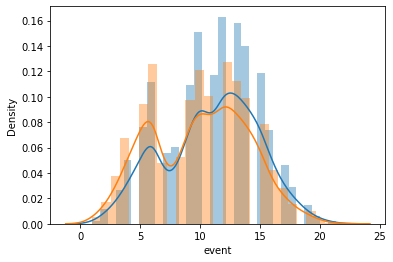

In [104]:
sns.distplot(first_day['event']);
sns.distplot(second_day['event']);

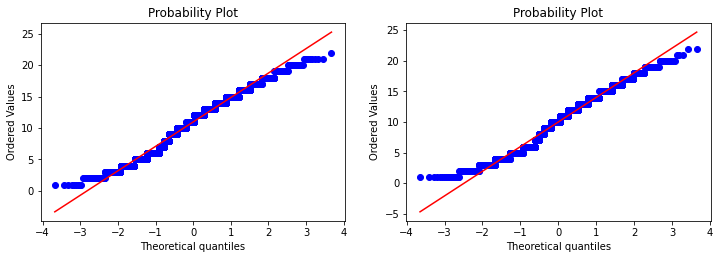

In [105]:
# строим qq-plot для нормального распределения
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
st.probplot(first_day['event'], dist="norm", plot=plt)
plt.subplot(2,2,2)
st.probplot(second_day['event'], dist="norm", plot=plt)
plt.show()

<p>Введем основную и альтернативные гипотезы:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Кол-во ивентов пользователей пришедших 4 мая и 5-6 мая одинаковое}\\
   H_1 :\text{Кол-во ивентов пользователей  пришедших 4 мая и 5-6 мая отличается}
 \end{cases}
\end{equation*}$

Уровень значимости: $\alpha = 0.05$

Если p-value будет меньше выбранного уровня значимости $\alpha = 0.05$, то нулевую гипотезу о равенстве средних отвергнем. Иначе сделаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.

In [106]:
alpha = 0.05
results = st.mannwhitneyu(first_day['event'], second_day['event'], alternative='two-sided')
print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  9.353294417397356e-34
Отвергаем нулевую гипотезу


$\begin{equation*}
 \begin{cases}
   H_0 :\text{Кол-во ивентов пользователей пришедших 4 мая и (5-6) мая одинаковое}\\
   H_1 :\text{Кол-во ивентов пользователей пришедших 4 мая больше чем  (5-6) мая}
 \end{cases}
\end{equation*}$

In [107]:
results = st.mannwhitneyu(first_day['event'], second_day['event'], alternative='greater')
print('p-значение: ', results.pvalue)
print(alpha)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  4.676647208698678e-34
0.05
Отвергаем нулевую гипотезу


### Вывод: 
Отвергаем нулевую гипотезу в пользу альтернативной "Кол-во ивентов пользователей пришедших 4 мая больше чем 5-6 мая"

Следовательно, можно сделать вывод, что львиная доля трафика рекламных компаний приходится на первый день, а не распределяется равномерно. 

в будущем, при сохранении подобной тактики, возможны такие последствия как перегруз серверов(когда в игре одновременно будут регистрироваться тысячи людей) и игра станет недоступна и компания потеряет потенциальных пользователей. 

Возможно, отделу маркетинга стоит пересмотреть стратегию рекламных компаний.

# Вывод: 

Проведен анализ рекламных источников и поведения игроков мобильной игры «Космические братья». 

В ходе исследования мы: 

1) Поготовили данные к анализу, привели типы колонок с датами в формат datetime, заполнили пропуск и удалили 1 дубликат. 

2) Проанализировали поведение игроков, выявили, что :

- Общий лайфтайм игроков длится 10 с половиной дней.


- Лайфтайм игроков, которые НЕ проходят на второй уровень длится 9 с половиной дней(медианно)


- Лайфтайм игроков, которые проходят на второй уровень длится 11 с половиной дней(медианно)


- Чаще всего игроки предпочитают строить здание типа космопорт(46.4%), потом  сборочный цех(42.6%), а вот  исследовательский центр строят очень редко, всего 11% от всех построек в игре.


- Из 13576 игроков, установивших приложение - на второй уровень перешли 5817(42%) - это зона Роста, конверсию нужно повышать.


- Из победителей у 1866(32%) были построены орбитальные сборки спутников, а 3951(68%) завершили игроку без этой постройки, а значит за победу над перым игроков. Т.е. 68% игроков предпочитают PVP, а 32 - PVE


-  PVE игроки чаще строят  исследовательский центр, а PVP-игроки сборочный цех. 


- Максимальная активность была с 4 по 10 мая(время рекламы), а потом стремительно снижалась. 


3) Провели Анализ рекламных источников и их влияние на игроков: 


- Со всех источников приходят +- одинаковые игроки, они имеют примерно равные показатели: 

1) Винрейта

2) Стиля игры

3) Активности

4) Лайфтайма



- Выявлены наиболее прибыльные для компании источники трафика: 

1) youtube_channel_reklama - имеет низкую стоимость лида 

2) yandex_direct - и хороший поток клиентов и не высокую стоимость лида




***Рекомендации отделу маркетинга***: 

- Направить силы рекламных компаний на  youtube_channel_reklama и yandex_direct, т.к. youtube_channel_reklama дает нам самых дешевых пользователей, а yandex_direct дает самое больший поток клиентов, по не самой высокой цене. 

- Снизить расходы на instagram_new_adverts и facebook_ads, т.к. эти каналы выходят неприемлемо дорогими на фоне своих конкурентов. 

- Обратить внимание на тактику ведения рекламных компаний, на данный момент самый большой трафик выпадает на первый день рекламной компании и постепенно снижается, в будущем, это может повлечь за собой перегруз серверов, когда тысячи пользователей регистрируются в 1 день   

***Рекомендации отделу Геймдизайна***: 

- Сбалансировать стратегии прохождения игры, на данный момент pvp стиль помогает пройти игру значительно быстре pve стиля. Из-за этого в игре уже есть серьезныйй уклон в pvp, 68% игроков предпочитают PVP. 

- Проработать вопрос увеличения конверсии прохождения 1 уровня(на текущий момент на 2 уровень проходит всего 42% игроков), а 57 пользователей совершили 1 ивент и сразу же вышли из игры. Возможно, игрокам что-то не понятно на этапе ввода в игровой процесс и они быстро теряют интерес

4) Проверены 2 статистические гипотезы: 

   1) ***Время завершения уровня различается в зависимости способа прохождения***: 
   
   $\begin{equation*}
 \begin{cases}
   H_0 :\text{Время прохождения 1 уровня пользователей  PVE и PVP одинаковое}\\
   H_1 :\text{Время прохождения 1 уровня у пользователей  PVE меньше чем у PVP}
 \end{cases}
\end{equation*}$


   ***Вывод***: Мы отвергаем нулевую гипотезу в пользу альтернативной: "Время прохождения 1 уровня у пользователей  PVE больше чем у   PVP"
   
   Следовательно, в игре присутствует быстрая стратегия прохождения уровня и баланс между PVP и PVE нарушен. Если не предпринять действий, то pve стратегия может совсем исчезнуть. 

   2) ***Кол-во ивентов пользователей пришедших с рекламы в первый день(04) и  во второй с третьим дни(05-06) отличаются***
    
$\begin{equation*}
\begin{cases}
H_0 :\text{Кол-во ивентов пользователей пришедших 4 мая и (5-6) мая одинаковое}\\
H_1 :\text{Кол-во ивентов пользователей пришедших 4 мая больше чем  (5-6) мая}
\end{cases}
\end{equation*}$

    

   ***Вывод***: Отвергаем нулевую гипотезу в пользу альтернативной "Кол-во ивентов пользователей пришедших 4 мая больше чем 5-6 мая"
    
    
    Следовательно, можно сделать вывод, что львиная доля трафика рекламных компаний приходится на первый день, а не распределяется равномерно. Возможны такие последствия как перегруз серверов(когда в игре одновременно будут регистрироваться тысячи людей) и игра станет недоступна и компания потеряет потенциальных пользователей. Возможно, отделу маркетинга стоит пересмотреть стратегию рекламных компаний.
    

